<center>
    <h1>Code for Bachelor's Thesis "Interpreting a Convolutional Text Classification Neural Network on a Clinical Dataset"</h1>
</center>

In this Jupyter Notebook is the code of a convolutional text classification neural network and its interpretation methods described in [Jacovi et al. (2018)](https://arxiv.org/abs/1809.08037) article.
This notebook is based on Ben Trevett's [PyTorch sentiment analysis tutorial](https://github.com/bentrevett/pytorch-sentiment-analysis). The base code of the interpretation methods was given by my supervisor.
The [DementiaBank](https://dementia.talkbank.org/) dataset is used in this analysis.

### Model parameters
* glove.6B.100D
* Batch size 32
* Four convolutional layers - uni, bi, tri and fourgrams.
* Dropout 0.4
* Adam optimizer
* BCE with logits loss
* 10 filters

In [1]:
from platform import python_version
print(python_version()) #Works on Python 3.6.8

#Set graphs directory path
dp = "graphs/"

3.6.8


In [2]:
%matplotlib inline

#Imports
import torch
import spacy
import random
import torch.optim as optim
from torchtext import data
from torchtext import datasets
from collections import Counter
import torch.nn.functional as F
import torch.nn as nn
from sklearn.cluster import MeanShift
import numpy as np
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import cycle
from random import choice
import statistics
import time

In [3]:
#Accuracy function
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8.
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds.float() == y).float()
    acc = correct.sum()/len(correct)
    return acc

#NN training
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label.float())
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#NN evaluation
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label.float())
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [4]:

def construct_tensor(test_item):
    """
    Returns a LongTensor from a given Batch test_item.
    """
    text = test_item.text
    indexed = [TEXT.vocab.stoi[t] for t in text]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    return tensor

def predict(test_item, tensor=False, return_class=True):
    """
    Returns the probability or class of the given test_item.
    """
    item = test_item
    if not tensor:
        item = construct_tensor(test_item)        
    score = torch.sigmoid(best_model(item)).squeeze()
    if return_class:
        return int(score.item() > 0.5)
    else:
        return score

        
def judgement(test_item, prediction):
    """
    Returns, how the given test_item was classified.
    """
    if prediction > 0.5: #Control group
        if test_item.label == 'C':
            return 'tn'#true negative
        elif test_item.label == 'P':
            return 'fn'#false negative
        else:
            print('judgement: This should never happen')
    else: #Patient
        if test_item.label == 'P':
            return 'tp'
        elif test_item.label == 'C':
            return 'fp'
        else:
            print('judgement: This should never happen')

#model.max_unigrams(tensor)
def get_pooled_vec(tensor, model):
    #Tagastab max-poolitud vektori
    a = model.max_unigrams(tensor)
    return a

In [5]:
#Reading data
spacy_en = spacy.load('en') #English tokenizer

def tokenizer(text):  #Create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

#Setting a seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED) #Seed for GPU
torch.backends.cudnn.deterministic = True

TEXT = data.Field(sequential=True, tokenize=tokenizer) #Setting the tokenizer
LABEL = data.LabelField(sequential=False, dtype=torch.float, unk_token=None) #Outputs 0 or 1

#Reading input data
train_data, dev_data, test_data = data.TabularDataset.splits(
        path='data/', train='train.tsv',
        validation='dev.tsv', test='test.tsv', format='tsv',
        fields=[('text', TEXT), ('label', LABEL)])

#Using pretrained word vectors
TEXT.build_vocab(train_data, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Try to use the GPU, whenever possible

train_iterator, dev_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, dev_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text), #PyTorch bug?
    repeat=False,
    device=device)

LABEL.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>, {'P': 0, 'C': 1})

In [6]:
def dict_size(d):
    """
    Outputs the dictionary size of the given dataset d.
    """
    Tdev = data.Field(sequential=True, tokenize=tokenizer) #Sõnestaja määramine

    train_data, dev_data, test_data = data.TabularDataset.splits(
            path='data/', train='train.tsv',
            validation='dev.tsv', test='test.tsv', format='tsv',
            fields=[('text', Tdev)])
    
    if d == "test":
        Tdev.build_vocab(test_data, vectors="glove.6B.100d")
    elif d == "dev":
        Tdev.build_vocab(dev_data, vectors="glove.6B.100d")
    return len(Tdev.vocab)

def average_wordlength(d):
    l = [len(t.text) for t in d]
    #for t in d:
        #l.append(len(t.text))
    return statistics.mean(l), statistics.stdev(l)

#Siin määrata andmestik
print("Number of input texts:")
print("Size of train set:", len(train_data))
print("Size of dev set:", len(dev_data))
print("Size of test set:", len(test_data))

dataset = train_data + dev_data
#dataset = train_data[:10]
print("Dataset size used for analysis:", len(dataset))

print("Average text length with standard deviation:")
print("Train", average_wordlength(train_data))
print("Dev", average_wordlength(dev_data))
print("Test", average_wordlength(test_data))

print("Train set dict size", len(TEXT.vocab))
print("Dev set dict size", dict_size("dev"))
print("Test set dict size", dict_size("test"))

Number of input texts:
Size of train set: 296
Size of dev set: 101
Size of test set: 101
Dataset size used for analysis: 397
Average text length with standard deviation:
Train (123.77364864864865, 63.1002923643999)
Dev (133.1980198019802, 63.65689590326883)
Test (122.85148514851485, 76.80877373563699)
Train set dict size 1321
Dev set dict size 818
Test set dict size 767


In [7]:
#Neural network
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim) #final classification
        self.dropout = nn.Dropout(dropout)
        self.fs = filter_sizes #number of filters
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        x = x.permute(1, 0)
        
        #x = [batch size, sent len]
        
        embedded = self.embedding(x)
        
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        #conved = [F.relu(conv(embedded).squeeze(3)) for conv in self.convs]
        
        conved = [conv(embedded).squeeze(3) for conv in self.convs]
        
        # conved = [batch size, n_filters, sent_len - filter_sizes[n]]
        
        #pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        pooled = [F.relu(F.max_pool1d(conv, conv.shape[2]).squeeze(2)) for conv in conved]
        
        # pooled_n = [batch size, n filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))
        
        return self.fc(cat)
    
    def max_unigrams(self, x):
        """
        Returns the max-pooled vector of all convolutional layers of the given item x.
        """
       
        #x = [sent len]
        
        x = x.permute(1, 0)
        embedded = self.embedding(x)
        
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [conv(embedded).squeeze(3) for conv in self.convs]
        
        # conved = [batch size, n_filters, sent_len - filter_sizes[n]]
        
        pooled_ind = [F.max_pool1d(conv, conv.shape[2], return_indices=True) for conv in conved]

        return pooled_ind
    
    def get_item_embedding(self, x):
        """
        Returns the given item x embedding layer.
        """
        #x = [sent len, batch size]
        
        x = x.permute(1, 0)
        
        #x = [batch size, sent len]
        
        embedded = self.embedding(x)
        
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        return embedded
    
    def get_filter_weights(self):
        """
        Returns the weights of all of the filters.
        """
        return [conv.weight.data.squeeze(1) for conv in self.convs]
        

In [8]:
#Creating the CNN

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 10
FILTER_SIZES = [1, 2, 3, 4]
OUTPUT_DIM = 1
DROPOUT = 0.4 #The probability of turning a neuron off

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [9]:
N_EPOCHS = 300

best_acc = 0
best_epoch = 0

#CHECK THE MODEL PATH
model_path = "chosen_model.pt"

"""
for epoch in range(N_EPOCHS):
    if epoch - best_epoch > 40:
        break

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, dev_iterator, criterion)

    if valid_acc >= best_acc:
        best_acc = valid_acc
        best_epoch = epoch
        best_loss = valid_loss
        torch.save(model.state_dict(), model_path) #Saving the model

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.3f}, Val. Acc: {valid_acc*100:.2f}%')

print(f'Best epoch: {best_epoch+1:d}, Best Acc: {best_acc*100:.2f}%')
"""

# Load the best model
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
best_model.load_state_dict(torch.load(model_path))

t_loss, t_acc = evaluate(best_model, test_iterator, criterion)
print(f'Test Loss: {t_loss:.3f}, Test Acc: {t_acc*100:.2f}%')
print("="*100)

Test Loss: 0.556, Test Acc: 82.03%


## Analysis
### Informative and uninformative ngrams

In [10]:
#Valib välja lineaarsest kihist õige filtri ja väljastab, mis liiki klassi tuvastab
def filter_class(model, filter_ind, ngram=2):
    """
    Picks the given ngram filter from final classification and returns Tensor(0) or Tensor(1) - which class that filter 
    identifies.
    """
    if filter_ind >= N_FILTERS:
        raise Exception("Filter index out of range, got " + str(filter_ind) + " but total number of filters is " 
                        + str(N_FILTERS))
        
    return (model.fc.weight.data > 0).squeeze()[10*FILTER_SIZES.index(ngram)+filter_ind] #Tensor(0) or Tensor(1)

def create_filter_data(model, data, filter_ind, ngram=2):
    """
    Returns a list of (weight, boolean, label) triplets from a given dataset
    """
    filter_data = []
    f_class = filter_class(model, filter_ind, ngram) #Tensor(0) or Tensor(1), filter class prediction
    for item in data:
        tensor = construct_tensor(item)
        
        #10 weights from the max-pooled vector of the given ngram
        pooled_vec = model.max_unigrams(tensor)[FILTER_SIZES.index(ngram)][0].squeeze()
        #pooled_vec = get_pooled_vec(tensor, model)[FILTER_SIZES.index(ngram)][0].squeeze()
        prediction = predict(tensor, tensor=True) #network prediction
        filter_data.append((pooled_vec[filter_ind], prediction==f_class, item.label))
        
    return filter_data
    #len(filter_data) == len(data)
    
def compute_threshold(data, purity_th=0.75, verbose=False):
    """
    Computes the threshold of the given dataset.
    """
    purity = 0.0
    step = 0.001
    th = 0
    while True:
        total = 0
        correct = 0
        correct_set = set()
        for i, (score, label, l) in enumerate(data): #(pooled_vec[filter_ind], prediction==f_class, item.label)
            if score >= th:
                total += 1
                if label == 1:
                    correct += 1
                    correct_set.add((i, l)) #(index, 'P/C')
        purity = 0.0
        if total > 0:
            purity = correct / total
        if verbose:
            print(f'Threshold: {th:f}, Correct: {correct:d}, Total: {total:d}, Purity: {purity:.3f}')
        if purity >= purity_th or total == 0:
            return th, correct, total, correct_set
        th += step

In [11]:
def calculate_accuracy(data, ths, classes):
    """
    Calculates the accuracy, given filter thresholds, of the dataset.
    """
    correct = 0
    for item in data:
        tensor = construct_tensor(item)

        counter = Counter()
        for ngram_ind in range(len(FILTER_SIZES)): #0, 1, 2, 3
            pooled = best_model.max_unigrams(tensor)[ngram_ind][0].squeeze()
            #pooled = get_pooled_vec(tensor, best_model)[ngram_ind][0].squeeze()
            for i, score in enumerate(pooled):
                if score > ths[ngram_ind][i]:
                    counter[classes[ngram_ind][i]] += 1
            if len(counter):
                label = max(counter, key=counter.get)
            else:
                label = choice(['P', 'C'])
            if label == item.label:
                correct += 1

    accuracy = correct / (len(FILTER_SIZES) * len(data))
    return accuracy

In [12]:
purity_ths = np.arange(100, 0, -1)*0.01
#purity_ths = [1, 0.8]
#print(list(purity_ths))
coverages = []
accuracies = []
thresholds = []
classes_all = []
filter_coverages_all = []
for purity_th in purity_ths:
    filter_set = defaultdict(set) #Muutsin asukohta
    ths = []
    classes = []
    filter_coverages = []
    coverage_correct = 0
    for ngram in FILTER_SIZES: #1, 2, 3, 4
        print(f'Looking at {ngram:d}-grams.')
        ths_sub = []
        classes_sub = []
        filter_coverages_sub = []
        for filter_ind in range(N_FILTERS): #0-9
            
            f_class = filter_class(best_model, filter_ind, ngram) #Tensor(0) or Tensor(1)
            
            #[(pooled_vec[filter_ind], prediction==f_class, item.label)]
            f_data = create_filter_data(best_model, dataset, filter_ind, ngram)
            
            f_th, f_correct, f_total, f_set = compute_threshold(f_data, purity_th=purity_th, verbose=False)
            coverage_correct += f_correct
            for ind, cl in f_set:
                filter_set[ind].add(filter_ind)
            print(f'Filter: {filter_ind:d}\t{LABEL.vocab.itos[f_class]}\t{f_th:.3f}\t{f_correct:d}\t{f_total:d}')
            ths_sub.append(f_th)
            classes_sub.append(LABEL.vocab.itos[f_class])
            if f_total != 0:
                filter_coverages_sub.append(f_correct/f_total * 100)
            else:
                filter_coverages_sub.append(0)
        ths.append(ths_sub)
        classes.append(classes_sub)
        filter_coverages.append(filter_coverages_sub)
    
    thresholds.append(ths)
    classes_all.append(classes)
    filter_coverages_all.append(filter_coverages)

    coverage = 1.0 * len(filter_set) / len(dataset) #Seda peab võibolla parandama
    coverages.append(coverage)
    accuracy = calculate_accuracy(test_data, ths, classes)
    accuracies.append(accuracy)
    print(f'purity: {purity_th:.2f}, coverage: {coverage:.3f}, accuracy: {accuracy:.4f}')
    print("-"*100)

Looking at 1-grams.
Filter: 0	P	3.038	0	0
Filter: 1	C	3.121	4	4
Filter: 2	P	3.177	0	0
Filter: 3	P	2.236	0	0
Filter: 4	P	3.356	0	0
Filter: 5	C	3.356	0	0
Filter: 6	P	3.301	17	17
Filter: 7	C	3.190	9	9
Filter: 8	C	1.074	0	0
Filter: 9	P	3.507	0	0
Looking at 2-grams.
Filter: 0	P	2.412	21	21
Filter: 1	P	3.315	7	7
Filter: 2	P	4.253	8	8
Filter: 3	C	2.009	8	8
Filter: 4	P	3.058	10	10
Filter: 5	P	3.357	2	2
Filter: 6	C	2.309	6	6
Filter: 7	P	3.350	7	7
Filter: 8	C	2.448	0	0
Filter: 9	C	3.442	0	0
Looking at 3-grams.
Filter: 0	P	2.519	14	14
Filter: 1	C	2.613	16	16
Filter: 2	P	2.240	27	27
Filter: 3	C	5.102	0	0
Filter: 4	C	2.855	0	0
Filter: 5	C	2.547	7	7
Filter: 6	P	3.335	2	2
Filter: 7	C	3.578	6	6
Filter: 8	P	4.127	8	8
Filter: 9	C	1.791	18	18
Looking at 4-grams.
Filter: 0	P	2.442	20	20
Filter: 1	C	3.796	9	9
Filter: 2	C	2.748	31	31
Filter: 3	C	4.295	6	6
Filter: 4	C	2.989	82	82
Filter: 5	P	2.696	28	28
Filter: 6	P	2.687	41	41
Filter: 7	C	4.685	15	15
Filter: 8	P	2.640	19	19
Filter: 9	C	3.126	9	9
purity: 1.00

Filter: 4	P	1.578	20	21
Filter: 5	C	3.356	0	0
Filter: 6	P	2.352	44	48
Filter: 7	C	2.879	49	56
Filter: 8	C	1.074	0	0
Filter: 9	P	3.507	0	0
Looking at 2-grams.
Filter: 0	P	1.774	58	64
Filter: 1	P	3.315	7	7
Filter: 2	P	2.062	93	108
Filter: 3	C	1.488	14	16
Filter: 4	P	1.901	99	115
Filter: 5	P	2.343	32	35
Filter: 6	C	1.066	109	125
Filter: 7	P	1.359	109	126
Filter: 8	C	2.448	0	0
Filter: 9	C	1.700	19	20
Looking at 3-grams.
Filter: 0	P	1.739	65	75
Filter: 1	C	2.491	27	30
Filter: 2	P	2.152	32	34
Filter: 3	C	1.704	124	141
Filter: 4	C	2.855	0	0
Filter: 5	C	2.435	18	20
Filter: 6	P	2.824	15	17
Filter: 7	C	3.451	16	18
Filter: 8	P	2.736	22	25
Filter: 9	C	0.495	128	148
Looking at 4-grams.
Filter: 0	P	0.721	149	173
Filter: 1	C	1.748	84	97
Filter: 2	C	1.617	105	122
Filter: 3	C	2.463	86	100
Filter: 4	C	1.021	157	182
Filter: 5	P	1.055	142	165
Filter: 6	P	1.335	119	138
Filter: 7	C	2.549	118	137
Filter: 8	P	1.158	139	159
Filter: 9	C	1.466	79	91
purity: 0.86, coverage: 0.990, accuracy: 0.6881
---------------

Filter: 3	C	0.193	187	256
Filter: 4	C	1.450	111	152
Filter: 5	C	0.457	166	227
Filter: 6	P	1.406	143	195
Filter: 7	C	1.128	142	194
Filter: 8	P	1.799	109	149
Filter: 9	C	0.064	168	230
Looking at 4-grams.
Filter: 0	P	0.277	172	235
Filter: 1	C	0.282	185	253
Filter: 2	C	0.470	169	231
Filter: 3	C	0.685	176	240
Filter: 4	C	0.091	185	253
Filter: 5	P	0.375	179	245
Filter: 6	P	0.725	167	228
Filter: 7	C	0.217	188	257
Filter: 8	P	0.690	185	253
Filter: 9	C	0.257	178	243
purity: 0.73, coverage: 1.000, accuracy: 0.7327
----------------------------------------------------------------------------------------------------
Looking at 1-grams.
Filter: 0	P	3.038	0	0
Filter: 1	C	0.299	155	215
Filter: 2	P	3.177	0	0
Filter: 3	P	2.236	0	0
Filter: 4	P	0.827	160	222
Filter: 5	C	0.175	181	251
Filter: 6	P	0.544	170	236
Filter: 7	C	0.575	154	212
Filter: 8	C	1.074	0	0
Filter: 9	P	1.976	79	109
Looking at 2-grams.
Filter: 0	P	0.814	148	205
Filter: 1	P	0.732	134	186
Filter: 2	P	0.663	176	244
Filter: 3	C	0.979	35	48
Filt

Filter: 5	C	0.000	189	282
Filter: 6	P	0.510	192	320
Filter: 7	C	0.000	193	321
Filter: 8	P	0.384	191	318
Filter: 9	C	0.000	175	247
Looking at 4-grams.
Filter: 0	P	0.000	183	286
Filter: 1	C	0.000	193	306
Filter: 2	C	0.000	177	278
Filter: 3	C	0.167	187	311
Filter: 4	C	0.000	186	264
Filter: 5	P	0.000	195	301
Filter: 6	P	0.048	188	313
Filter: 7	C	0.000	193	275
Filter: 8	P	0.115	198	330
Filter: 9	C	0.000	184	269
purity: 0.60, coverage: 1.000, accuracy: 0.6386
----------------------------------------------------------------------------------------------------
Looking at 1-grams.
Filter: 0	P	3.038	0	0
Filter: 1	C	0.000	178	280
Filter: 2	P	2.262	98	164
Filter: 3	P	0.616	59	100
Filter: 4	P	0.010	188	317
Filter: 5	C	0.000	188	291
Filter: 6	P	0.000	184	285
Filter: 7	C	0.000	189	308
Filter: 8	C	0.007	189	317
Filter: 9	P	0.049	193	324
Looking at 2-grams.
Filter: 0	P	0.373	193	326
Filter: 1	P	0.238	181	306
Filter: 2	P	0.039	197	331
Filter: 3	C	0.359	173	293
Filter: 4	P	0.005	190	317
Filter: 5	P	1.098

Filter: 0	P	0.000	196	362
Filter: 1	C	0.000	191	313
Filter: 2	P	0.000	198	354
Filter: 3	C	0.000	188	268
Filter: 4	C	0.000	186	295
Filter: 5	C	0.000	189	282
Filter: 6	P	0.000	201	391
Filter: 7	C	0.000	193	321
Filter: 8	P	0.000	200	382
Filter: 9	C	0.000	175	247
Looking at 4-grams.
Filter: 0	P	0.000	183	286
Filter: 1	C	0.000	193	306
Filter: 2	C	0.000	177	278
Filter: 3	C	0.000	195	340
Filter: 4	C	0.000	186	264
Filter: 5	P	0.000	195	301
Filter: 6	P	0.000	191	322
Filter: 7	C	0.000	193	275
Filter: 8	P	0.000	200	355
Filter: 9	C	0.000	184	269
purity: 0.47, coverage: 1.000, accuracy: 0.5941
----------------------------------------------------------------------------------------------------
Looking at 1-grams.
Filter: 0	P	0.000	201	397
Filter: 1	C	0.000	178	280
Filter: 2	P	0.000	201	397
Filter: 3	P	0.000	201	397
Filter: 4	P	0.000	191	330
Filter: 5	C	0.000	188	291
Filter: 6	P	0.000	184	285
Filter: 7	C	0.000	189	308
Filter: 8	C	0.000	190	327
Filter: 9	P	0.000	197	348
Looking at 2-grams.
Filter: 0	P

Filter: 5	P	0.000	201	397
Filter: 6	C	0.000	185	318
Filter: 7	P	0.000	198	353
Filter: 8	C	0.000	195	326
Filter: 9	C	0.000	190	345
Looking at 3-grams.
Filter: 0	P	0.000	196	362
Filter: 1	C	0.000	191	313
Filter: 2	P	0.000	198	354
Filter: 3	C	0.000	188	268
Filter: 4	C	0.000	186	295
Filter: 5	C	0.000	189	282
Filter: 6	P	0.000	201	391
Filter: 7	C	0.000	193	321
Filter: 8	P	0.000	200	382
Filter: 9	C	0.000	175	247
Looking at 4-grams.
Filter: 0	P	0.000	183	286
Filter: 1	C	0.000	193	306
Filter: 2	C	0.000	177	278
Filter: 3	C	0.000	195	340
Filter: 4	C	0.000	186	264
Filter: 5	P	0.000	195	301
Filter: 6	P	0.000	191	322
Filter: 7	C	0.000	193	275
Filter: 8	P	0.000	200	355
Filter: 9	C	0.000	184	269
purity: 0.34, coverage: 1.000, accuracy: 0.5941
----------------------------------------------------------------------------------------------------
Looking at 1-grams.
Filter: 0	P	0.000	201	397
Filter: 1	C	0.000	178	280
Filter: 2	P	0.000	201	397
Filter: 3	P	0.000	201	397
Filter: 4	P	0.000	191	330
Filter: 5	C

Filter: 0	P	0.000	201	391
Filter: 1	P	0.000	196	368
Filter: 2	P	0.000	197	349
Filter: 3	C	0.000	194	349
Filter: 4	P	0.000	190	333
Filter: 5	P	0.000	201	397
Filter: 6	C	0.000	185	318
Filter: 7	P	0.000	198	353
Filter: 8	C	0.000	195	326
Filter: 9	C	0.000	190	345
Looking at 3-grams.
Filter: 0	P	0.000	196	362
Filter: 1	C	0.000	191	313
Filter: 2	P	0.000	198	354
Filter: 3	C	0.000	188	268
Filter: 4	C	0.000	186	295
Filter: 5	C	0.000	189	282
Filter: 6	P	0.000	201	391
Filter: 7	C	0.000	193	321
Filter: 8	P	0.000	200	382
Filter: 9	C	0.000	175	247
Looking at 4-grams.
Filter: 0	P	0.000	183	286
Filter: 1	C	0.000	193	306
Filter: 2	C	0.000	177	278
Filter: 3	C	0.000	195	340
Filter: 4	C	0.000	186	264
Filter: 5	P	0.000	195	301
Filter: 6	P	0.000	191	322
Filter: 7	C	0.000	193	275
Filter: 8	P	0.000	200	355
Filter: 9	C	0.000	184	269
purity: 0.21, coverage: 1.000, accuracy: 0.5941
----------------------------------------------------------------------------------------------------
Looking at 1-grams.
Filter: 0	P

Filter: 5	C	0.000	188	291
Filter: 6	P	0.000	184	285
Filter: 7	C	0.000	189	308
Filter: 8	C	0.000	190	327
Filter: 9	P	0.000	197	348
Looking at 2-grams.
Filter: 0	P	0.000	201	391
Filter: 1	P	0.000	196	368
Filter: 2	P	0.000	197	349
Filter: 3	C	0.000	194	349
Filter: 4	P	0.000	190	333
Filter: 5	P	0.000	201	397
Filter: 6	C	0.000	185	318
Filter: 7	P	0.000	198	353
Filter: 8	C	0.000	195	326
Filter: 9	C	0.000	190	345
Looking at 3-grams.
Filter: 0	P	0.000	196	362
Filter: 1	C	0.000	191	313
Filter: 2	P	0.000	198	354
Filter: 3	C	0.000	188	268
Filter: 4	C	0.000	186	295
Filter: 5	C	0.000	189	282
Filter: 6	P	0.000	201	391
Filter: 7	C	0.000	193	321
Filter: 8	P	0.000	200	382
Filter: 9	C	0.000	175	247
Looking at 4-grams.
Filter: 0	P	0.000	183	286
Filter: 1	C	0.000	193	306
Filter: 2	C	0.000	177	278
Filter: 3	C	0.000	195	340
Filter: 4	C	0.000	186	264
Filter: 5	P	0.000	195	301
Filter: 6	P	0.000	191	322
Filter: 7	C	0.000	193	275
Filter: 8	P	0.000	200	355
Filter: 9	C	0.000	184	269
purity: 0.08, coverage: 1.000,

In [13]:
best_accuracy_index = accuracies.index(max(accuracies))
correct_purity = purity_ths[best_accuracy_index]
correct_filter_coverage = filter_coverages_all[best_accuracy_index]
correct_classes = classes_all[best_accuracy_index]
correct_thresholds = thresholds[best_accuracy_index]

print("On this dataset, the 'correct' purity is", correct_purity, "and the test accuracy achieved is", accuracies[best_accuracy_index])

On this dataset, the 'correct' purity is 0.74 and the test accuracy achieved is 0.7400990099009901


In [14]:
def plot_filter_coverage(coverages, ngram):
    plt.bar(range(N_FILTERS), coverages)
    plt.xticks(range(N_FILTERS))
    plt.xlabel("Filter")
    plt.ylabel("Ngram coverage (%)")
    plt.title("Filters " + str(ngram) + "-gram coverage")
    plt.savefig(dp + "filter-coverages-"+str(ngram)+"-grams", bbox_inches='tight')
    plt.show()

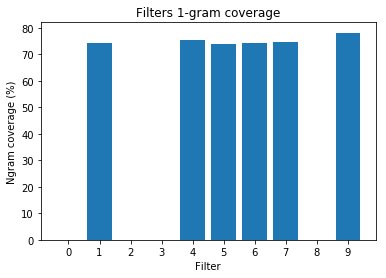

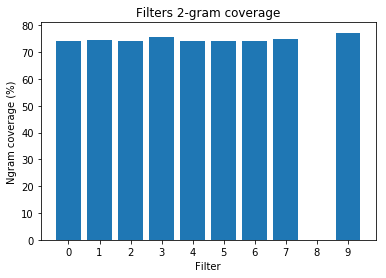

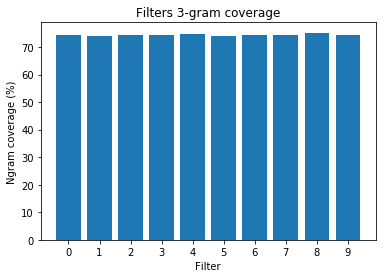

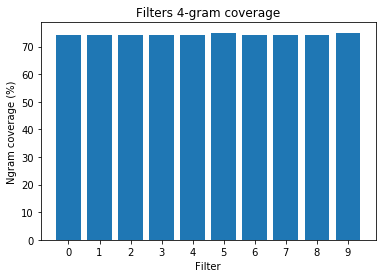

In [15]:
for ngram_ind, filter_coverage in enumerate(correct_filter_coverage):
    plot_filter_coverage(filter_coverage, FILTER_SIZES[ngram_ind])

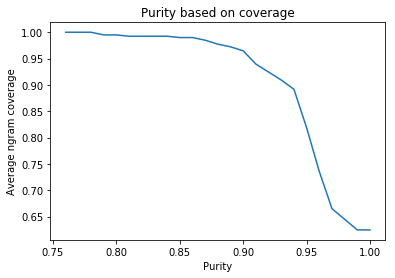

In [16]:
k = 25
plt.plot(purity_ths[:k], coverages[:k])
plt.xlabel("Purity")
plt.ylabel("Average ngram coverage")
plt.title("Purity based on coverage")
plt.savefig(dp + '/purity-coverage.png', bbox_inches='tight')
plt.show()

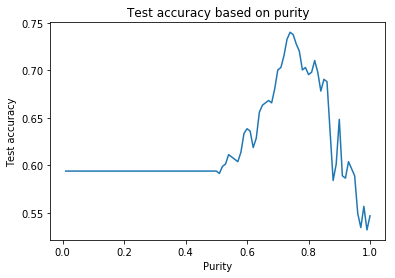

In [17]:
plt.plot(purity_ths, accuracies)
plt.xlabel("Purity")
plt.ylabel("Test accuracy")
plt.title("Test accuracy based on purity")
plt.savefig(dp + '/purity-accuracy.png', bbox_inches='tight')
plt.show()

## Slot activation vector analysis

In [10]:
def generate_slot_activation_vectors(data):
    """
    Creates all slot activation vectors as triplets (filter index, ngram, activations).
    """    
    result = []

    for item_index, item in enumerate(data): #Iterate over dataset
        example = construct_tensor(item)
        v2 = best_model.get_item_embedding(example).squeeze() #v2 - embedding matrix
        for ngram_ind, ngram in enumerate(FILTER_SIZES): #1, 2-grams
            for filter_ind in range(N_FILTERS): #10 filters
                v1 = best_model.get_filter_weights()[ngram_ind][filter_ind] #v1 - filter weights
                for embedding_slice_index in range(len(v2) - ngram + 1): #slice the embedding
                    ngram_word = v2[embedding_slice_index:embedding_slice_index+ngram] #get the ngram
                    slotvalues = []
                    for slot_ind in range(ngram): #ngram slot index
                        embedding_slot = ngram_word[slot_ind]
                        filter_slot = v1[slot_ind]
                        activation = torch.dot(filter_slot.view(-1), embedding_slot.view(-1))
                        slotvalues.append(activation.item())
                    t = (filter_ind, tuple(data[item_index].text[embedding_slice_index:embedding_slice_index+ngram]), tuple(slotvalues))
                    result.append(t)
    return result

In [11]:
result = generate_slot_activation_vectors(dataset)
result_set = list(set(result))

In [ ]:
#Slot activation vectors which pass the threshold
result_th = []
for row in result:
    ngram = len(row[1])
    filter_ind = row[0]
    act = sum(row[2])
    th = correct_thresholds[FILTER_SIZES.index(ngram)][filter_ind]
    if act > th:
        result_th.append(row)
result_th_set = list(set(result_th))

In [ ]:
print("The length of slot activation vectors list is", len(result))
print("Without duplicates", len(result_set))

print("The length of slot activation vectors list that pass the threshold is", len(result_th))
print("Without duplicates", len(result_th_set))

In [22]:
#Top ngrams by filter - table 1 left
def printout1(data):
    for row in data[:1]:
        print(row[0], 
              " ".join(row[1]), 
              round(sum(row[2]), 2), "\t\t",
              ([round(a, 2) for a in row[2]]))

def get_top_ngrams(data, ngram=2, f=0):
    a = filter(lambda e: len(e[2]) == ngram and e[0] == f, data)
    return sorted(a, key=lambda e: sum(e[2]), reverse=True) #Return the whole list and not a slice

for ngram_ind in FILTER_SIZES:
    print("Observing", ngram_ind, "-grams.")
    for filter_ind in range(N_FILTERS):
        printout1(get_top_ngrams(result_set, ngram_ind, filter_ind))
    print()

Observing 1 -grams.
0 floor 3.04 		 [3.04]
1 space 3.56 		 [3.56]
2 some 3.14 		 [3.14]
3 by 2.28 		 [2.28]
4 huh 3.41 		 [3.41]
5 open 3.44 		 [3.44]
6 helping 5.98 		 [5.98]
7 lip 4.0 		 [4.0]
8 bench 1.04 		 [1.04]
9 chair 3.48 		 [3.48]

Observing 2 -grams.
0 went overboard 5.1 		 [3.33, 1.77]
1 some plates 4.35 		 [3.07, 1.28]
2 shh quiet 5.03 		 [4.35, 0.69]
3 kitchen cabinets 2.81 		 [1.64, 1.18]
4 spilled , 4.15 		 [2.98, 1.18]
5 my ! 4.07 		 [2.73, 1.35]
6 living room 3.37 		 [2.0, 1.38]
7 help and 4.24 		 [3.89, 0.35]
8 the stool 2.49 		 [0.67, 1.81]
9 wind is 3.46 		 [2.29, 1.17]

Observing 3 -grams.
0 hm hm cup 3.89 		 [1.28, 1.97, 0.63]
1 towards her mouth 4.82 		 [1.69, 1.13, 2.01]
2 's kinda sloppy 3.73 		 [1.38, 1.03, 1.31]
3 stool is tipping 5.15 		 [0.97, 0.6, 3.59]
4 . um mother 2.92 		 [-0.13, 0.74, 2.31]
5 birds , geese 3.51 		 [1.76, 0.38, 1.37]
6 bottom ? mama 5.38 		 [2.57, 0.59, 2.22]
7 towards her mouth 3.82 		 [2.44, -0.02, 1.39]
8 saying “ shh 6.12 		 [1.88,

In [23]:
#Top words by filter and slot
def printout2(data, slot_ind):
    print((data[1][slot_ind]), 
          round(data[2][slot_ind], 2), end="\t\t")
    
def get_top_words_by_slot(data, ngram=2, f=0, slot=0, top=10):
    if slot >= ngram:
        raise Exception("For ngram dimension " + str(ngram) + " max slot value is " + str(ngram-1))
    a = filter(lambda e: len(e[2]) == ngram and e[0] == f, result)
    return sorted(a, key=lambda e: e[2][slot], reverse=True)[0]

for ngram_ind in FILTER_SIZES[1:]:
    print("Observing", ngram_ind, "-grams.")
    for f_ind in range(N_FILTERS):
        print(f_ind, end="\t")
        
        for slot_ind in range(ngram_ind):
            printout2(get_top_words_by_slot(result_set, ngram_ind, f_ind, slot=slot_ind), slot_ind)
        print()

Observing 2 -grams.
0	went 3.33		eaten 3.17		
1	some 3.07		mama 1.98		
2	shh 4.35		hm 2.61		
3	kitchen 1.64		cabinets 1.18		
4	spilled 2.98		, 1.18		
5	my 2.73		percent 2.06		
6	people 2.61		billowing 1.93		
7	venture 3.89		salient 1.97		
8	the 0.67		stool 1.81		
9	wind 2.29		is 1.17		
Observing 3 -grams.
0	hm 1.28		hm 1.97		flooding 1.83		
1	raising 1.75		open 1.44		mouth 2.01		
2	lady 1.78		hm 1.45		spilled 2.51		
3	overflowing 2.13		condition 1.23		tipping 3.59		
4	whew 1.04		towards 1.05		mother 2.31		
5	towards 2.24		shrub 1.0		stool 1.84		
6	bottom 2.57		forgot 1.4		pan 2.27		
7	towards 2.44		uh 0.82		stool 2.18		
8	mommy 2.03		“ 1.36		mama 2.93		
9	arm 2.27		groomed 2.3		weeds 1.05		
Observing 4 -grams.
0	tair 1.3		hm 1.08		huh 2.17		dinner 2.19		
1	nine 0.94		towards 1.31		tea 1.5		mouth 2.63		
2	dishes 1.29		uh 1.38		towards 2.23		lid 2.92		
3	coffee 2.21		overflowing 3.37		expression 1.23		um 1.86		
4	wind 1.79		are 2.35		slower 1.96		wet 1.68		
5	p 2.6		huh 2.96		dear 2.74		

In [24]:
#Printout3

#Top-k ngrams by filter scores
def get_top_k_ngrams(data, ngram=2, topk=10):
    a = filter(lambda e: len(e[2]) == ngram, data)
    return sorted(a, key=lambda e: sum(e[2]), reverse=True)[:topk]

for ngram_ind in FILTER_SIZES:
    print("Observing", ngram_ind, "-grams.")
    for i, row in enumerate(get_top_k_ngrams(result_set, ngram_ind)):
        print(i+1, " ".join(row[1]), "f" + str(row[0]), round(sum(row[2]), 2), row[2])
    print()  

Observing 1 -grams.
1 helping f6 5.98 (5.982271194458008,)
2 help f6 5.07 (5.065610885620117,)
3 poor f6 4.1 (4.096992492675781,)
4 worst f6 4.01 (4.011255264282227,)
5 lip f7 4.0 (3.9966423511505127,)
6 space f1 3.56 (3.5622596740722656,)
7 arm f7 3.5 (3.5025930404663086,)
8 chair f9 3.48 (3.4793541431427,)
9 open f5 3.44 (3.444608688354492,)
10 huh f4 3.41 (3.405409812927246,)

Observing 2 -grams.
1 went overboard f0 5.1 (3.329599618911743, 1.7740423679351807)
2 shh quiet f2 5.03 (4.346358776092529, 0.688072919845581)
3 pearl mom f2 4.88 (3.978816509246826, 0.8972835540771484)
4 hm hm f2 4.85 (2.2414474487304688, 2.606325626373291)
5 shh to f2 4.69 (4.346358776092529, 0.3408050537109375)
6 plates waiting f2 4.57 (3.766970634460449, 0.8052118420600891)
7 shh while f2 4.51 (4.346358776092529, 0.16197869181632996)
8 some plates f1 4.35 (3.071073055267334, 1.2836503982543945)
9 shh . f2 4.32 (4.346358776092529, -0.025183260440826416)
10 shh ” f2 4.32 (4.346358776092529, -0.02577126771211

In [25]:
#Top-k words by slot scores
def printout4(data):
    for row in data:
        print(row[0], "f" + str(row[2]), round(row[1], 2))
        
def get_top_k_words_by_slot(data, ngram=2, slot=0, topk=10):
    a = []
    a = filter(lambda e: len(e[2]) == ngram, data)
    b = set()
    for row in a:
        b.add((row[1][slot], row[2][slot], row[0]))
    return sorted(b, key=lambda e: e[1], reverse=True)[:topk]

for ngram_ind in FILTER_SIZES[1:]:
    print("Observing", ngram_ind, "-grams.")
    for slot_ind in range(ngram_ind):
        print()
        print("Slot", slot_ind+1)
        printout4(get_top_k_words_by_slot(result_set, ngram_ind, slot=slot_ind))
    print("-"*100)

Observing 2 -grams.

Slot 1
shh f2 4.35
pearl f2 3.98
venture f7 3.89
help f7 3.89
plates f2 3.77
whew f2 3.7
mama f2 3.68
cake f2 3.52
dinner f2 3.44
went f0 3.33

Slot 2
eaten f0 3.17
hm f2 2.61
mama f0 2.24
percent f5 2.06
tin f5 1.99
mama f1 1.98
windows f5 1.98
salient f7 1.97
billowing f6 1.93
jars f1 1.93
----------------------------------------------------------------------------------------------------
Observing 3 -grams.

Slot 1
bottom f6 2.57
towards f7 2.44
reach f6 2.3
arm f9 2.27
towards f5 2.24
overflowing f3 2.13
mommy f8 2.03
saying f8 1.88
leg f6 1.86
finger f9 1.86

Slot 2
groomed f9 2.3
hm f0 1.97
uh f0 1.55
hek f0 1.55
hm f2 1.45
open f1 1.44
huh f0 1.42
forgot f6 1.4
“ f8 1.36
his f8 1.32

Slot 3
tipping f3 3.59
motioning f3 3.22
overflowing f3 3.02
mama f8 2.93
shh f8 2.87
overflow f3 2.72
um f3 2.71
drooping f3 2.65
spilled f2 2.51
crawling f3 2.37
----------------------------------------------------------------------------------------------------
Observing 4 -g

### Clustering

In [27]:
#Mean Shift Clustering

bigrams = []
trigrams = []
fourgrams = []

#As a set
bigrams_s = []
trigrams_s = []
fourgrams_s = []

#Threshold passing
bigrams_th = []
trigrams_th = []
fourgrams_th = []

#Threshold passing as a set
bigrams_th_s = []
trigrams_th_s = []
fourgrams_th_s = []

for filter_ind in range(N_FILTERS):
    filter_bigrams = [(s) for (f, n, s) in result if len(n) == 2 and f==filter_ind]
    bigrams.append(filter_bigrams)
    filter_trigrams = [(s) for (f, n, s) in result if len(n) == 3 and f==filter_ind]
    trigrams.append(filter_trigrams)
    filter_fourgrams = [(s) for (f, n, s) in result if len(n) == 4 and f==filter_ind]
    fourgrams.append(filter_fourgrams)
    
    filter_bigrams_s = [(s) for (f, n, s) in result_set if len(n) == 2 and f==filter_ind]
    bigrams_s.append(filter_bigrams_s)
    filter_trigrams_s = [(s) for (f, n, s) in result_set if len(n) == 3 and f==filter_ind]
    trigrams_s.append(filter_trigrams_s)
    filter_fourgrams_s = [(s) for (f, n, s) in result_set if len(n) == 4 and f==filter_ind]
    fourgrams_s.append(filter_fourgrams_s)
    
    filter_bigrams_th = [(s) for (f, n, s) in result_th if len(n) == 2 and f==filter_ind]
    bigrams_th.append(filter_bigrams_th)
    filter_trigrams_th = [(s) for (f, n, s) in result_th if len(n) == 3 and f==filter_ind]
    trigrams_th.append(filter_trigrams_th)
    filter_fourgrams_th = [(s) for (f, n, s) in result_th if len(n) == 4 and f==filter_ind]
    fourgrams_th.append(filter_fourgrams_th)
    
    filter_bigrams_th_s = [(s) for (f, n, s) in result_th_set if len(n) == 2 and f==filter_ind]
    bigrams_th_s.append(filter_bigrams_th_s)
    filter_trigrams_th_s = [(s) for (f, n, s) in result_th_set if len(n) == 3 and f==filter_ind]
    trigrams_th_s.append(filter_trigrams_th_s)
    filter_fourgrams_th_s = [(s) for (f, n, s) in result_th_set if len(n) == 4 and f==filter_ind]
    fourgrams_th_s.append(filter_fourgrams_th_s)

In [28]:
def do_clustering(ngrams, cluster_all=True):
    """
    Applies mean shift clustering on the given slot activation vector dataset.
    """
    X = []
    clustering = []
    print("Looking at filter", end=" ")
    for filter_ind in range(N_FILTERS):
        print(filter_ind, end=" ")
        X_h = np.array(ngrams[filter_ind])
        clustering_h = MeanShift(cluster_all=cluster_all).fit(X_h)
        X.append(X_h)
        clustering.append(clustering_h)
    print("Finished.")
    return X, clustering

In [29]:
def do_clustering4(ngrams, cluster_all=True):
    X = []
    clustering = []
    print("Looking at filter", end=" ")
    
    print("4", end=" ")
    X_h = np.array(ngrams[4])
    clustering_h = MeanShift(cluster_all=cluster_all).fit(X_h)
    X.append(X_h)
    clustering.append(clustering_h)
    print("Finished.")
    return X, clustering

In [30]:
def print_clustering_information(clustering):
    print("Observing", len(clustering[0].cluster_centers_[0]), "-grams.")
    
    for filter_ind in range(N_FILTERS):
        print("Filter", filter_ind, "centers", clustering[filter_ind].cluster_centers_)
        clc = collections.Counter(clustering[filter_ind].labels_)
        print("Number of clusters:", len(clc))
        for i in clc:
            print("Number of instances in cluster", i, clc[i], round(clc[i]/len(clustering[filter_ind].labels_) * 100, 4), "%")
        print()

In [31]:
# #############################################################################
# Plot result

def graph_clusters(filter_ind, clustering, X, lisatekst):
    labels = clustering.labels_
    cluster_centers = clustering.cluster_centers_
    print(cluster_centers)

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    plt.figure(1)
    plt.clf()

    plt.xlabel("First word activation")
    plt.ylabel("Second word activation")
    
    plt.xlim(-2, 4)
    plt.xticks(np.arange(-2, 3+1, 1.0))

    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(len(cluster_centers)), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
    plt.title("Filter %d with %d clusters %s" %(filter_ind, len(cluster_centers), lisatekst))
    plt.savefig(dp + "/clusters-f" + lisatekst + str(filter_ind), bbox_inches='tight')
    plt.show()

In [32]:
#Bigrams with duplicates, all clustered
X2, clustering2 = do_clustering(bigrams)
print_clustering_information(clustering2)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[-0.43114214 -0.2881296 ]
 [ 2.03248568 -0.18159207]
 [ 3.32959962  0.44480678]
 [ 1.99114235  1.16283274]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 6
Number of instances in cluster 0 49326 99.2615 %
Number of instances in cluster 1 270 0.5433 %
Number of instances in cluster 2 8 0.0161 %
Number of instances in cluster 3 67 0.1348 %
Number of instances in cluster 5 21 0.0423 %
Number of instances in cluster 4 1 0.002 %

Filter 1 centers [[-0.20823567 -0.87443662]
 [ 3.04566069 -0.51193977]]
Number of clusters: 2
Number of instances in cluster 0 49526 99.6639 %
Number of instances in cluster 1 167 0.3361 %

Filter 2 centers [[-1.17656241 -0.06713738]
 [ 2.15170863 -0.09892878]
 [ 3.15770717 -0.13841453]
 [-0.87568693  2.60632563]
 [ 3.75047886  0.13076996]
 [ 2.24144745  2.60632563]
 [ 1.96109581  1.71493733]
 [ 2.24144745 -1.78210104]]
Number of clusters: 8
Number of i

[[-0.43114214 -0.2881296 ]
 [ 2.03248568 -0.18159207]
 [ 3.32959962  0.44480678]
 [ 1.99114235  1.16283274]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


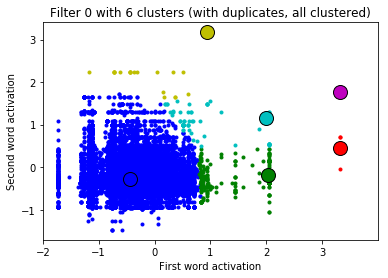

[[-0.20823567 -0.87443662]
 [ 3.04566069 -0.51193977]]


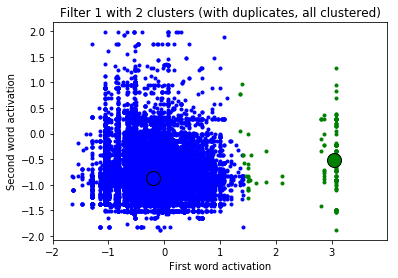

[[-1.17656241 -0.06713738]
 [ 2.15170863 -0.09892878]
 [ 3.15770717 -0.13841453]
 [-0.87568693  2.60632563]
 [ 3.75047886  0.13076996]
 [ 2.24144745  2.60632563]
 [ 1.96109581  1.71493733]
 [ 2.24144745 -1.78210104]]


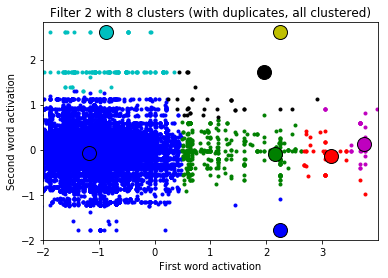

[[-0.39637092 -0.63739256]
 [-1.39764651  0.51224644]
 [-0.33956233  0.75917008]
 [ 1.54545953 -0.53257658]
 [ 1.63561845  1.04474737]
 [ 1.63561845  0.53288995]]


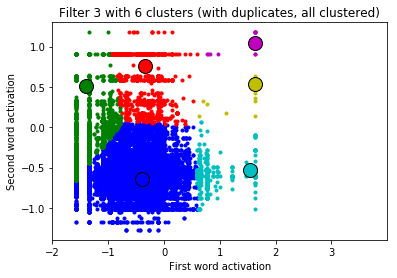

[[-0.95466941 -0.20896188]
 [ 2.12879119  0.046846  ]
 [ 1.43321891 -0.145375  ]
 [ 2.83986955 -0.27452632]
 [ 2.79972148  1.03417397]]


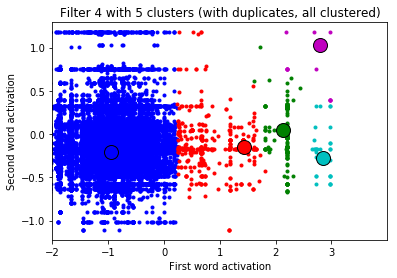

[[ 0.04091208  0.0200218 ]
 [ 1.71154682 -0.75771861]
 [ 1.70520121  0.2337581 ]
 [ 0.10811952  1.60991842]
 [ 2.72579598  0.25461365]
 [ 2.72579598 -0.846231  ]
 [ 2.72579598  1.34813964]
 [ 1.82203162  1.63753366]]


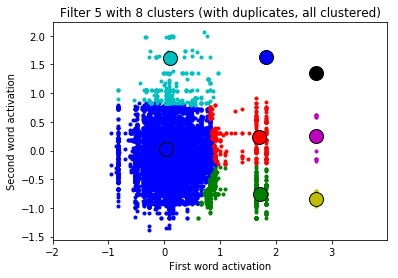

[[-0.53672233 -1.01809227]
 [ 1.41905571 -0.40149401]
 [ 0.82563049  1.15220627]
 [ 2.18825065 -0.43712517]
 [ 2.30145653 -1.12164913]
 [ 1.72065747  1.26335478]]


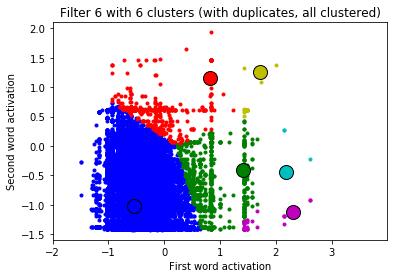

[[-0.53508902 -0.2038904 ]
 [ 1.15538299  0.11489304]
 [ 1.60769502 -0.04689426]
 [ 2.58833726  0.18538019]
 [ 3.89133358  0.16856721]
 [ 3.00723386  0.91279793]
 [-0.25094682  1.96911871]]


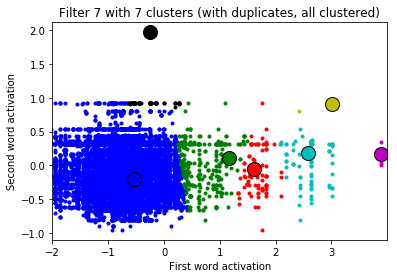

[[-0.57251017 -1.44891992]
 [ 0.41293731  1.81235173]
 [-0.80366147  1.81494319]
 [-1.45401381  1.81494319]]


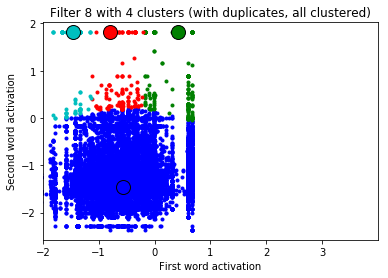

[[-1.16751919 -0.42879543]
 [-1.4699563   1.14215709]
 [ 0.25967891  1.14001488]
 [ 2.29368782  1.16891587]
 [ 2.29368782 -0.62700338]
 [ 1.20894039  1.08164752]
 [ 2.29368782  0.2896807 ]]


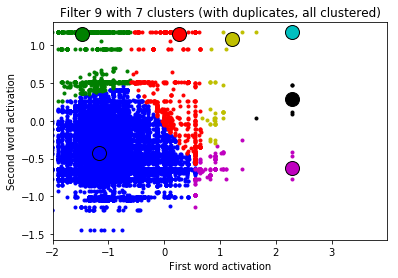

In [33]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2[filter_ind], X2[filter_ind], "(with duplicates, all clustered)")

In [34]:
#Bigrams without duplicates, all clustered
X2_s, clustering2_s = do_clustering(bigrams_s)
print_clustering_information(clustering2_s)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[-0.32650664 -0.22525866]
 [ 1.93860221 -0.06246571]
 [ 0.01356442  2.10774271]
 [ 3.32959962  0.39837688]
 [ 1.96143174  1.097251  ]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 7
Number of instances in cluster 0 10208 96.8317 %
Number of instances in cluster 1 133 1.2616 %
Number of instances in cluster 2 182 1.7264 %
Number of instances in cluster 3 4 0.0379 %
Number of instances in cluster 4 13 0.1233 %
Number of instances in cluster 5 1 0.0095 %
Number of instances in cluster 6 1 0.0095 %

Filter 1 centers [[-0.12981082 -0.82748805]
 [ 3.00726736 -0.18433853]]
Number of clusters: 2
Number of instances in cluster 0 10475 99.3644 %
Number of instances in cluster 1 67 0.6356 %

Filter 2 centers [[-1.15529744 -0.02171134]
 [ 1.92386839  0.00663729]
 [ 3.14075877 -0.0463937 ]
 [-1.19393282  2.60632563]
 [ 2.24144745  2.60632563]
 [ 1.96109581  1.71493733]]
Number of clust

[[-0.32650664 -0.22525866]
 [ 1.93860221 -0.06246571]
 [ 0.01356442  2.10774271]
 [ 3.32959962  0.39837688]
 [ 1.96143174  1.097251  ]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


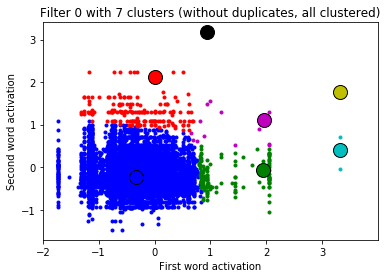

[[-0.12981082 -0.82748805]
 [ 3.00726736 -0.18433853]]


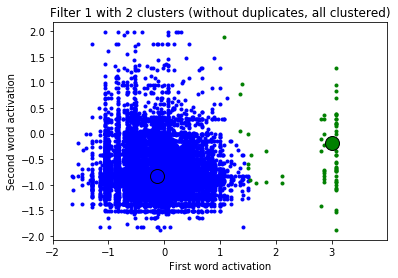

[[-1.15529744 -0.02171134]
 [ 1.92386839  0.00663729]
 [ 3.14075877 -0.0463937 ]
 [-1.19393282  2.60632563]
 [ 2.24144745  2.60632563]
 [ 1.96109581  1.71493733]]


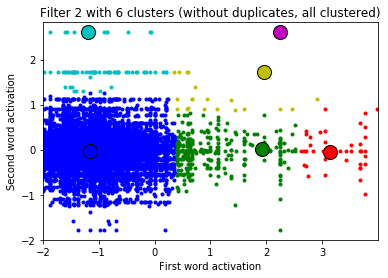

[[-0.40828524 -0.60023735]
 [ 1.52005028 -0.56755325]
 [ 1.63561845  0.24052895]]


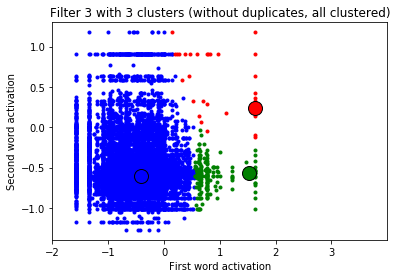

[[-0.88905543 -0.13009845]
 [ 1.35823601 -0.15664883]
 [ 1.92784865 -0.06163141]
 [ 2.83153477 -0.12070307]
 [ 2.64550209  1.06995022]]


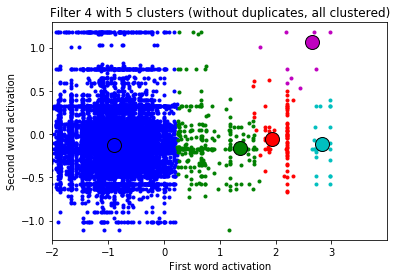

[[ 0.06429394 -0.0426354 ]
 [ 1.69960599 -0.01609301]
 [ 1.71517434 -0.5038003 ]
 [ 2.72579598  0.15452742]
 [ 2.72579598 -0.87913243]
 [ 2.72579598  1.34813964]
 [ 1.82203162  1.63753366]]


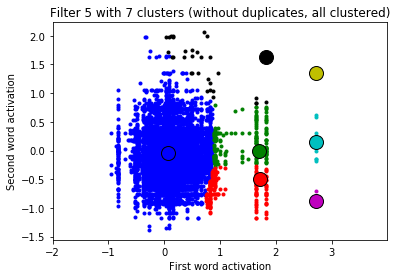

[[-0.37846005 -0.70874604]
 [ 2.30145653 -1.14214331]
 [ 1.72065747  1.26335478]
 [ 0.6917331   1.68098978]
 [ 2.37928557 -0.33590971]]


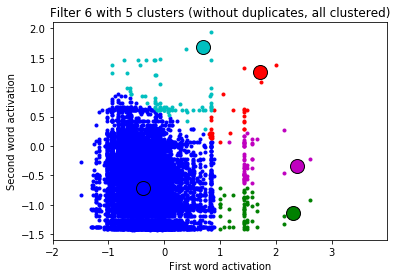

[[-0.61443755 -0.14244981]
 [ 1.48993837 -0.01724918]
 [ 2.40739339  0.07118305]
 [ 3.89157677  0.14844071]
 [ 3.00723386  0.91279793]
 [-0.25094682  1.96911871]]


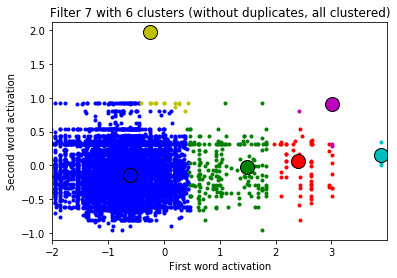

[[-0.55959379 -1.37446943]
 [-0.37556008  1.73544049]]


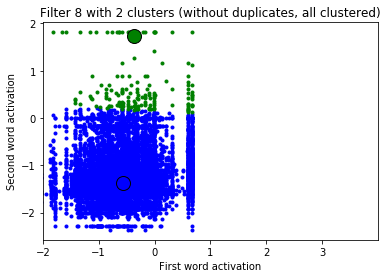

[[-1.07947847 -0.33861165]
 [-1.10626341  1.06107318]
 [ 2.29368782 -0.39397989]
 [ 1.20894039  1.08164752]
 [ 2.29368782  0.22764613]
 [ 2.29368782  1.16891587]]


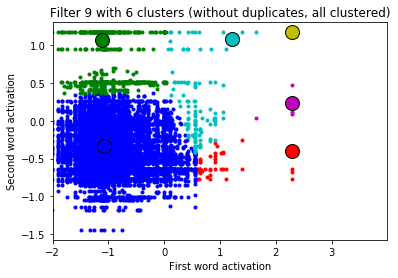

In [35]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2_s[filter_ind], X2_s[filter_ind], "(without duplicates, all clustered)")

In [36]:
#Bigrams with duplicates, some clustered
X2_o, clustering2_o = do_clustering(bigrams, cluster_all=False)
print_clustering_information(clustering2_o)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[-0.43114214 -0.2881296 ]
 [ 2.03248568 -0.18159207]
 [ 3.32959962  0.44480678]
 [ 1.99114235  1.16283274]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 7
Number of instances in cluster 0 29029 58.4167 %
Number of instances in cluster -1 20558 41.37 %
Number of instances in cluster 1 93 0.1871 %
Number of instances in cluster 2 8 0.0161 %
Number of instances in cluster 4 1 0.002 %
Number of instances in cluster 3 3 0.006 %
Number of instances in cluster 5 1 0.002 %

Filter 1 centers [[-0.20823567 -0.87443662]
 [ 3.04566069 -0.51193977]]
Number of clusters: 3
Number of instances in cluster 0 27714 55.7704 %
Number of instances in cluster -1 21888 44.0464 %
Number of instances in cluster 1 91 0.1831 %

Filter 2 centers [[-1.17656241 -0.06713738]
 [ 2.15170863 -0.09892878]
 [ 3.15770717 -0.13841453]
 [-0.87568693  2.60632563]
 [ 3.75047886  0.13076996]
 [ 2.24144745  2.606325

[[-0.43114214 -0.2881296 ]
 [ 2.03248568 -0.18159207]
 [ 3.32959962  0.44480678]
 [ 1.99114235  1.16283274]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


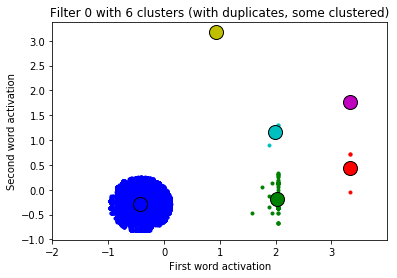

[[-0.20823567 -0.87443662]
 [ 3.04566069 -0.51193977]]


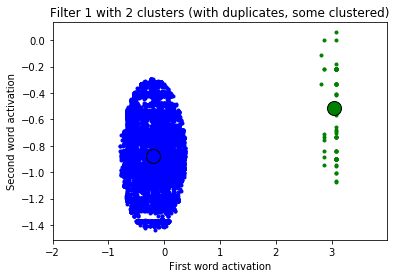

[[-1.17656241 -0.06713738]
 [ 2.15170863 -0.09892878]
 [ 3.15770717 -0.13841453]
 [-0.87568693  2.60632563]
 [ 3.75047886  0.13076996]
 [ 2.24144745  2.60632563]
 [ 1.96109581  1.71493733]
 [ 2.24144745 -1.78210104]]


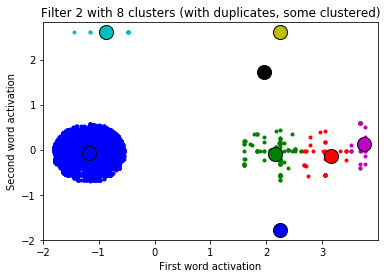

[[-0.39637092 -0.63739256]
 [-1.39764651  0.51224644]
 [-0.33956233  0.75917008]
 [ 1.54545953 -0.53257658]
 [ 1.63561845  1.04474737]
 [ 1.63561845  0.53288995]]


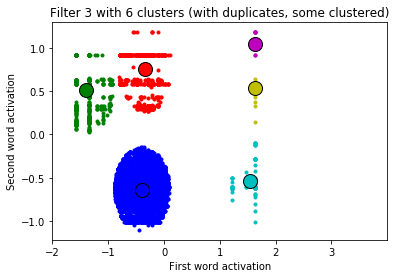

[[-0.95466941 -0.20896188]
 [ 2.12879119  0.046846  ]
 [ 1.43321891 -0.145375  ]
 [ 2.83986955 -0.27452632]
 [ 2.79972148  1.03417397]]


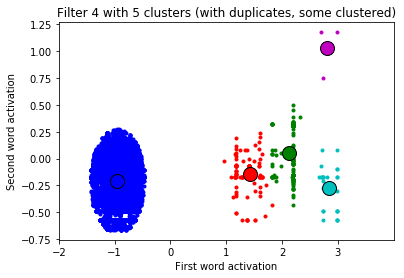

[[ 0.04091208  0.0200218 ]
 [ 1.71154682 -0.75771861]
 [ 1.70520121  0.2337581 ]
 [ 0.10811952  1.60991842]
 [ 2.72579598  0.25461365]
 [ 2.72579598 -0.846231  ]
 [ 2.72579598  1.34813964]
 [ 1.82203162  1.63753366]]


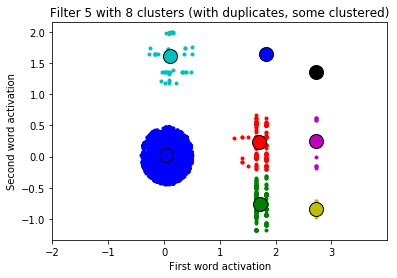

[[-0.53672233 -1.01809227]
 [ 1.41905571 -0.40149401]
 [ 0.82563049  1.15220627]
 [ 2.18825065 -0.43712517]
 [ 2.30145653 -1.12164913]
 [ 1.72065747  1.26335478]]


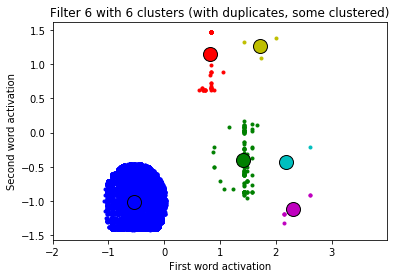

[[-0.53508902 -0.2038904 ]
 [ 1.15538299  0.11489304]
 [ 1.60769502 -0.04689426]
 [ 2.58833726  0.18538019]
 [ 3.89133358  0.16856721]
 [ 3.00723386  0.91279793]
 [-0.25094682  1.96911871]]


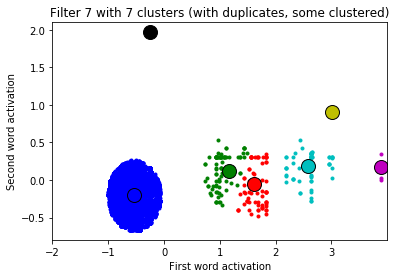

[[-0.57251017 -1.44891992]
 [ 0.41293731  1.81235173]
 [-0.80366147  1.81494319]
 [-1.45401381  1.81494319]]


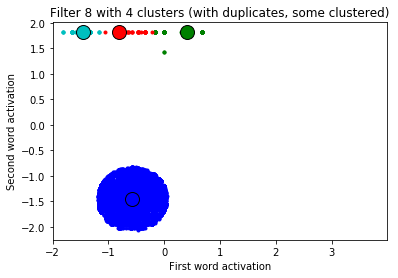

[[-1.16751919 -0.42879543]
 [-1.4699563   1.14215709]
 [ 0.25967891  1.14001488]
 [ 2.29368782  1.16891587]
 [ 2.29368782 -0.62700338]
 [ 1.20894039  1.08164752]
 [ 2.29368782  0.2896807 ]]


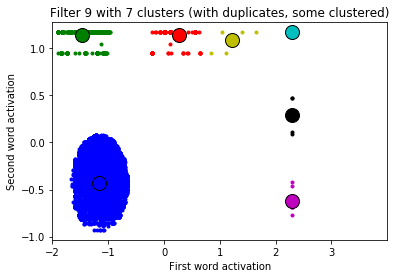

In [37]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2_o[filter_ind], X2_o[filter_ind], "(with duplicates, some clustered)")

In [38]:
#Bigrams without duplicates, some clustered
X2_os, clustering2_os = do_clustering(bigrams_s, cluster_all=False)
print_clustering_information(clustering2_os)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[-0.32650664 -0.22525866]
 [ 1.93860221 -0.06246571]
 [ 0.01356442  2.10774271]
 [ 3.32959962  0.39837688]
 [ 1.96143174  1.097251  ]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 8
Number of instances in cluster -1 4049 38.4083 %
Number of instances in cluster 0 6435 61.0415 %
Number of instances in cluster 3 4 0.0379 %
Number of instances in cluster 1 42 0.3984 %
Number of instances in cluster 5 1 0.0095 %
Number of instances in cluster 2 8 0.0759 %
Number of instances in cluster 4 2 0.019 %
Number of instances in cluster 6 1 0.0095 %

Filter 1 centers [[-0.12981082 -0.82748805]
 [ 3.00726736 -0.18433853]]
Number of clusters: 3
Number of instances in cluster -1 4434 42.0603 %
Number of instances in cluster 0 6074 57.6172 %
Number of instances in cluster 1 34 0.3225 %

Filter 2 centers [[-1.15529744 -0.02171134]
 [ 1.92386839  0.00663729]
 [ 3.14075877 -0.0463937 ]
 [-1.1

[[-0.32650664 -0.22525866]
 [ 1.93860221 -0.06246571]
 [ 0.01356442  2.10774271]
 [ 3.32959962  0.39837688]
 [ 1.96143174  1.097251  ]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


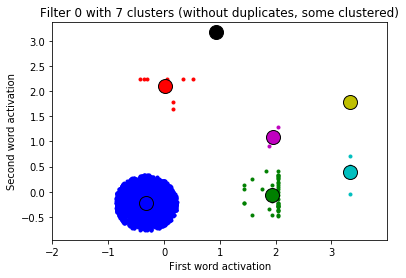

[[-0.12981082 -0.82748805]
 [ 3.00726736 -0.18433853]]


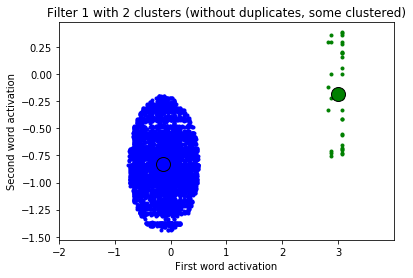

[[-1.15529744 -0.02171134]
 [ 1.92386839  0.00663729]
 [ 3.14075877 -0.0463937 ]
 [-1.19393282  2.60632563]
 [ 2.24144745  2.60632563]
 [ 1.96109581  1.71493733]]


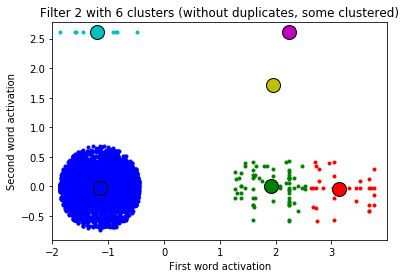

[[-0.40828524 -0.60023735]
 [ 1.52005028 -0.56755325]
 [ 1.63561845  0.24052895]]


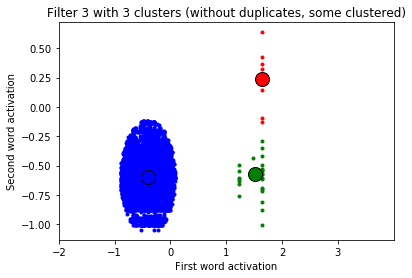

[[-0.88905543 -0.13009845]
 [ 1.35823601 -0.15664883]
 [ 1.92784865 -0.06163141]
 [ 2.83153477 -0.12070307]
 [ 2.64550209  1.06995022]]


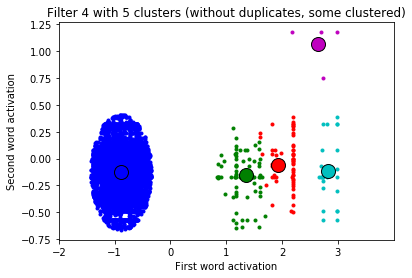

[[ 0.06429394 -0.0426354 ]
 [ 1.69960599 -0.01609301]
 [ 1.71517434 -0.5038003 ]
 [ 2.72579598  0.15452742]
 [ 2.72579598 -0.87913243]
 [ 2.72579598  1.34813964]
 [ 1.82203162  1.63753366]]


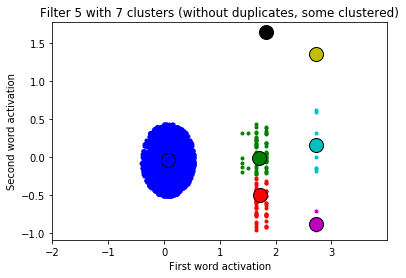

[[-0.37846005 -0.70874604]
 [ 2.30145653 -1.14214331]
 [ 1.72065747  1.26335478]
 [ 0.6917331   1.68098978]
 [ 2.37928557 -0.33590971]]


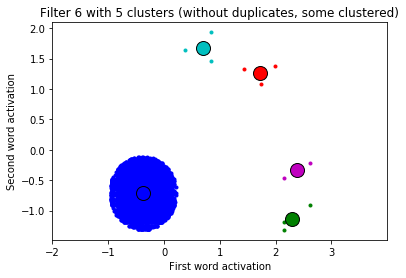

[[-0.61443755 -0.14244981]
 [ 1.48993837 -0.01724918]
 [ 2.40739339  0.07118305]
 [ 3.89157677  0.14844071]
 [ 3.00723386  0.91279793]
 [-0.25094682  1.96911871]]


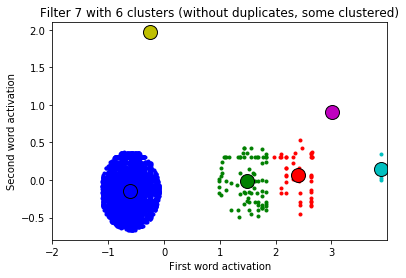

[[-0.55959379 -1.37446943]
 [-0.37556008  1.73544049]]


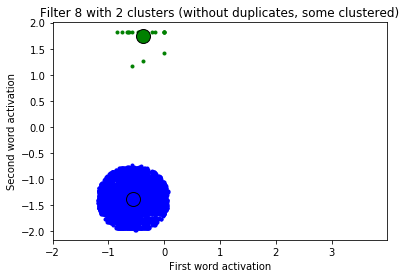

[[-1.07947847 -0.33861165]
 [-1.10626341  1.06107318]
 [ 2.29368782 -0.39397989]
 [ 1.20894039  1.08164752]
 [ 2.29368782  0.22764613]
 [ 2.29368782  1.16891587]]


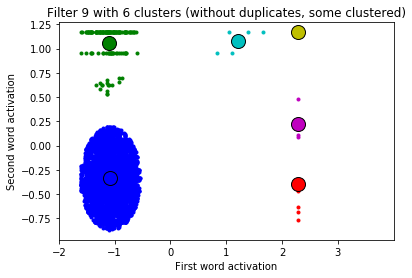

In [39]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2_os[filter_ind], X2_os[filter_ind], "(without duplicates, some clustered)")

### Clustering trigrams and fourgrams

Takes computationally a long time.

In [40]:
#Trigrams with duplicates, all clustered
X3, clustering3 = do_clustering(trigrams)
print_clustering_information(clustering3)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 3 -grams.
Filter 0 centers [[-1.24910548 -0.71648786 -0.07642175]
 [-1.58833295  1.17710198 -0.02819058]]
Number of clusters: 2
Number of instances in cluster 0 46631 94.5939 %
Number of instances in cluster 1 2665 5.4061 %

Filter 1 centers [[-0.85056342 -0.21139935 -0.81560674]
 [ 1.0124599  -0.23514534  1.18626611]
 [-0.91866091  1.12723744  1.70986488]
 [-0.92425715  1.14722882  1.02459459]
 [ 0.32692117  1.12723744  1.15322347]
 [ 1.64487468  1.12723744  1.65582177]
 [ 1.66677499  1.12723744 -0.13048996]]
Number of clusters: 7
Number of instances in cluster 0 47824 97.014 %
Number of instances in cluster 3 542 1.0995 %
Number of instances in cluster 6 321 0.6512 %
Number of instances in cluster 1 488 0.9899 %
Number of instances in cluster 4 68 0.1379 %
Number of instances in cluster 5 11 0.0223 %
Number of instances in cluster 2 42 0.0852 %

Filter 2 centers [[-0.66830777 -1.40618129 -0.23785817]
 [-0.78598928  1.44809985 

In [ ]:
#Trigrams without duplicates, all clustered
X3_s, clustering3_s = do_clustering(trigrams_s)
print_clustering_information(clustering3_s)

In [ ]:
#Trigrams with duplicates, some clustered
X3_o, clustering3_o = do_clustering(trigrams, cluster_all=False)
print_clustering_information(clustering3_o)

In [ ]:
#Trigrams without duplicates, some clustered
X3_os, clustering3_os = do_clustering(trigrams_s, cluster_all=False)
print_clustering_information(clustering3_os)

In [ ]:
t0 = time.time()
#Fourgrams with duplicates, all clustered
X4, clustering4 = do_clustering(fourgrams)
print_clustering_information(clustering4)
print("Time in seconds:", round(time.time() - t0))

In [ ]:
#Fourgrams without duplicates, all clustered
X4_s, clustering4_s = do_clustering(fourgrams_s)
print_clustering_information(clustering4_s)

In [ ]:
#Fourgrams with duplicates, some clustered
X4_o, clustering4_o = do_clustering(fourgrams, cluster_all=False)
print_clustering_information(clustering4_o)

In [ ]:
#Fourgrams without duplicates, some clustered
X4_os, clustering4_os = do_clustering(fourgrams_s, cluster_all=False)
print_clustering_information(clustering4_os)

### Clustering of only threshold passing slot activation vectors
#### Bigrams

In [42]:
#1
#Bigrams with duplicates, all clustered, threshold passing
X2_th, clustering2_th = do_clustering(bigrams_th, cluster_all=True)
print_clustering_information(clustering2_th)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[ 0.37740684  0.81143797]
 [ 1.95845398 -0.12660791]
 [ 3.32959962  0.44480678]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 5
Number of instances in cluster 1 125 30.7882 %
Number of instances in cluster 2 8 1.9704 %
Number of instances in cluster 0 264 65.0246 %
Number of instances in cluster 4 6 1.4778 %
Number of instances in cluster 3 3 0.7389 %

Filter 1 centers [[ 3.04229302 -0.32489782]
 [ 0.59810543  0.67135589]]
Number of clusters: 2
Number of instances in cluster 0 142 46.4052 %
Number of instances in cluster 1 164 53.5948 %

Filter 2 centers [[ 1.51164474  0.12181766]
 [-0.36756513  1.81850762]
 [ 2.12930679  2.24977031]]
Number of clusters: 3
Number of instances in cluster 0 356 67.0433 %
Number of instances in cluster 1 162 30.5085 %
Number of instances in cluster 2 13 2.4482 %

Filter 3 centers [[ 1.63299702 -0.48320434]
 [ 0.27686202  0.94256679]
 [ 1.6356

[[ 0.37740684  0.81143797]
 [ 1.95845398 -0.12660791]
 [ 3.32959962  0.44480678]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


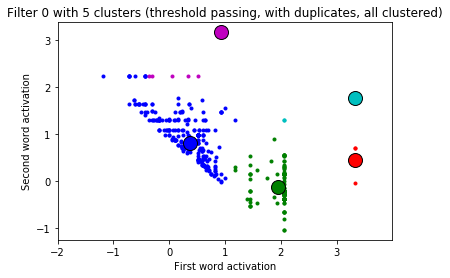

[[ 3.04229302 -0.32489782]
 [ 0.59810543  0.67135589]]


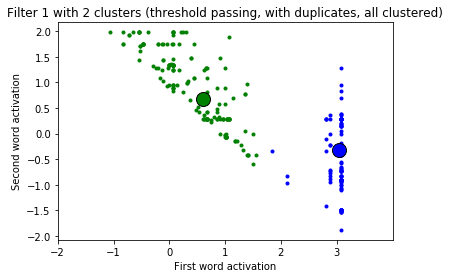

[[ 1.51164474  0.12181766]
 [-0.36756513  1.81850762]
 [ 2.12930679  2.24977031]]


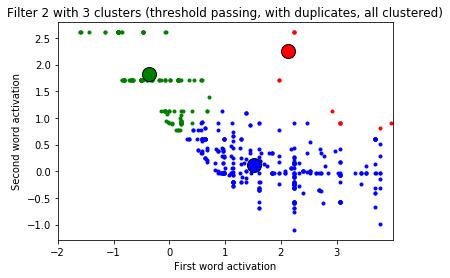

[[ 1.63299702 -0.48320434]
 [ 0.27686202  0.94256679]
 [ 1.63561845  1.04474737]
 [ 0.75374237  0.3579734 ]]


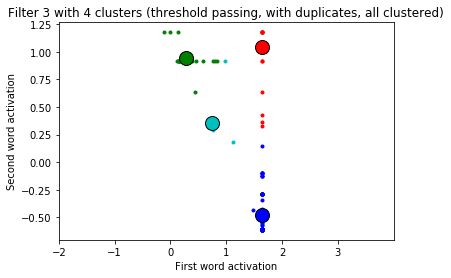

[[ 1.8189356  -0.07142814]
 [-0.08896079  1.00413184]]


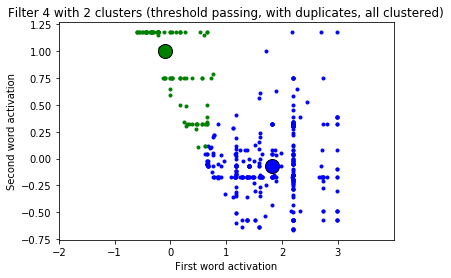

[[1.70631629 0.4685363 ]
 [0.30695112 1.86508297]
 [2.72579598 0.25461365]
 [2.72579598 1.34813964]
 [1.82203162 1.63753366]]


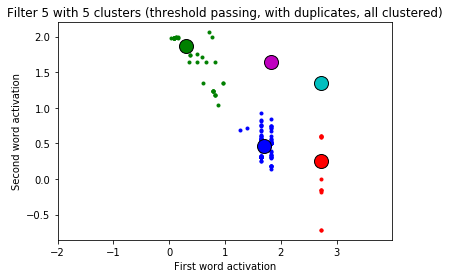

[[1.01061385 0.04751371]]


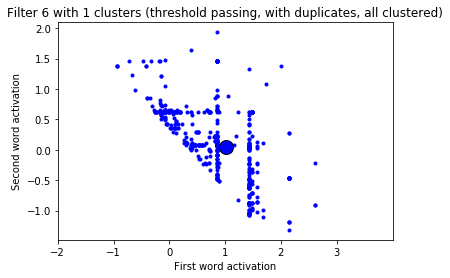

[[ 0.58309624  0.25125433]
 [ 3.89133358  0.16856721]
 [-0.25094682  1.96911871]]


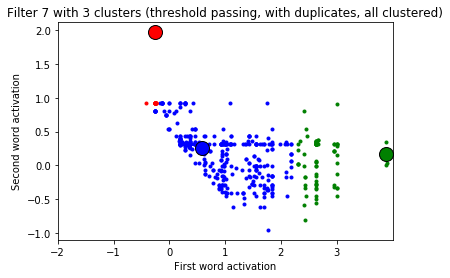

[[0.6717416  1.81494319]]


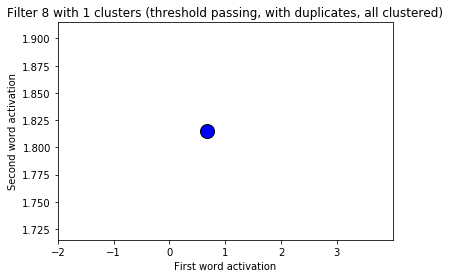

[[ 0.5510258   1.16891587]
 [ 0.11476931  1.16891587]
 [ 2.29368782  1.16891587]
 [ 2.29368782 -0.62700338]
 [ 0.89148057  0.5039795 ]
 [ 0.67272576  0.95074499]
 [ 0.3691637   0.95074499]
 [ 2.29368782  0.47578439]
 [ 2.29368782  0.10357701]
 [ 1.65153241  1.16891587]
 [ 1.65153241  0.03034361]
 [ 1.39890027  1.16891587]
 [ 1.10625219  0.95074499]
 [ 1.04556608  1.16891587]]


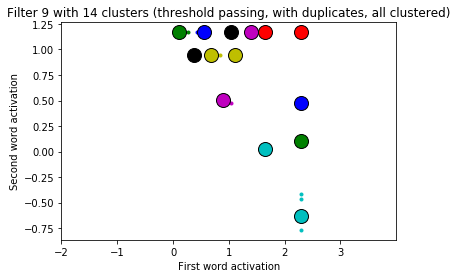

In [43]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2_th[filter_ind], X2_th[filter_ind], "(threshold passing, with duplicates, all clustered)")

In [44]:
#2
#Bigrams without duplicates, all clustered, threshold passing
X2_th_s, clustering2_th_s = do_clustering(bigrams_th_s, cluster_all=True)
print_clustering_information(clustering2_th_s)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[ 0.34777967  0.85547211]
 [ 1.86278227 -0.06177826]
 [ 3.32959962  0.39837688]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 5
Number of instances in cluster 0 179 72.1774 %
Number of instances in cluster 1 59 23.7903 %
Number of instances in cluster 4 4 1.6129 %
Number of instances in cluster 3 2 0.8065 %
Number of instances in cluster 2 4 1.6129 %

Filter 1 centers [[ 0.51758685  0.79344317]
 [ 2.96979567 -0.43941124]]
Number of clusters: 2
Number of instances in cluster 1 58 35.1515 %
Number of instances in cluster 0 107 64.8485 %

Filter 2 centers [[1.45571953 0.15926236]
 [2.10127163 2.16063148]]
Number of clusters: 2
Number of instances in cluster 0 249 90.5455 %
Number of instances in cluster 1 26 9.4545 %

Filter 3 centers [[ 0.36522357  0.93062382]
 [ 1.62419653 -0.44170179]
 [ 1.63561845  0.24052895]
 [ 0.75374237  0.3579734 ]]
Number of clusters: 4
Number of in

[[ 0.34777967  0.85547211]
 [ 1.86278227 -0.06177826]
 [ 3.32959962  0.39837688]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


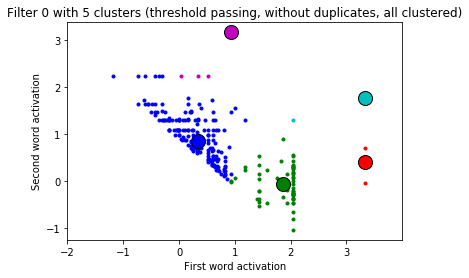

[[ 0.51758685  0.79344317]
 [ 2.96979567 -0.43941124]]


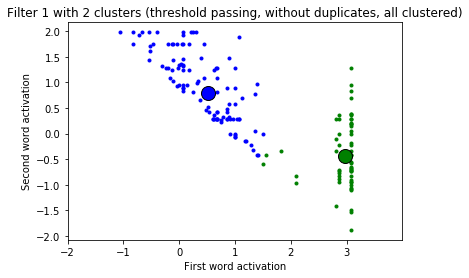

[[1.45571953 0.15926236]
 [2.10127163 2.16063148]]


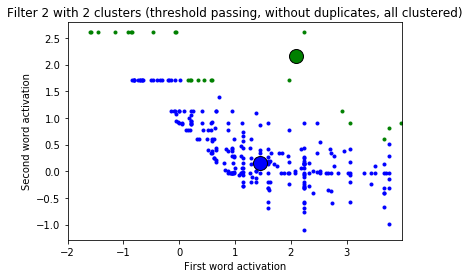

[[ 0.36522357  0.93062382]
 [ 1.62419653 -0.44170179]
 [ 1.63561845  0.24052895]
 [ 0.75374237  0.3579734 ]]


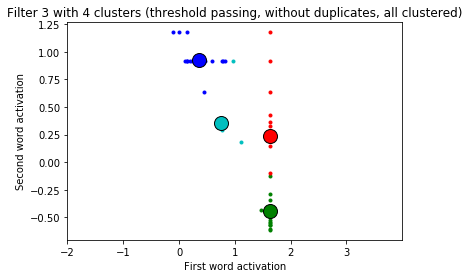

[[ 1.71683255 -0.08399431]
 [ 0.07678921  0.84015977]]


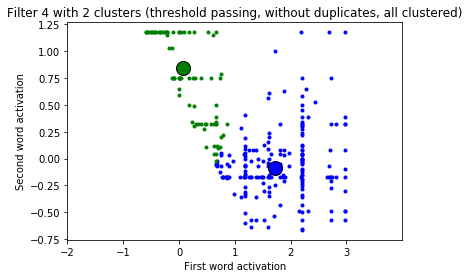

[[1.71296088 0.52080748]
 [0.50163037 1.71329954]
 [2.72579598 0.15452742]
 [2.72579598 1.34813964]
 [1.82203162 1.63753366]]


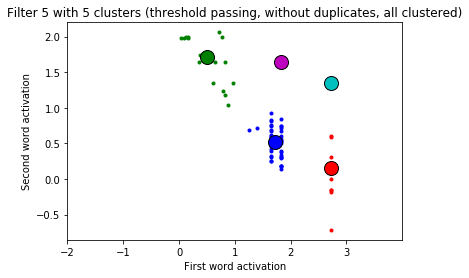

[[ 0.36457905  0.34462007]
 [ 0.99633769 -0.08830433]
 [ 2.37928557 -0.32688653]]


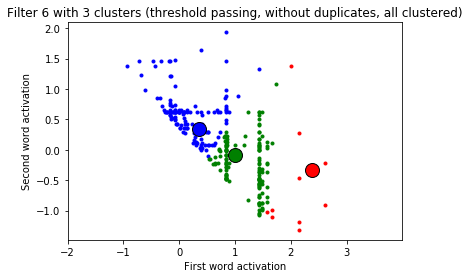

[[ 1.20217515 -0.01352546]
 [ 3.89157677  0.14844071]
 [-0.25094682  1.96911871]]


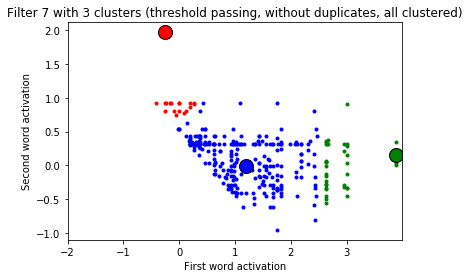

[[0.6717416  1.81494319]]


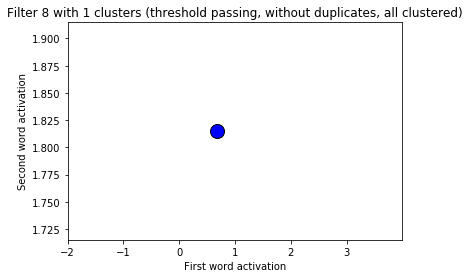

[[ 0.55890952  1.00151641]
 [ 2.29368782 -0.39397989]
 [ 1.7813735   1.16891587]]


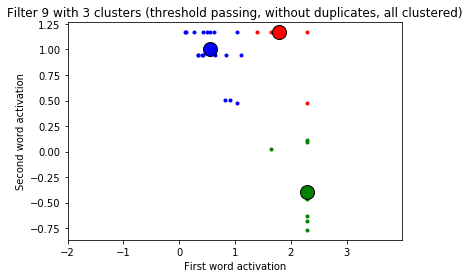

In [45]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2_th_s[filter_ind], X2_th_s[filter_ind], "(threshold passing, without duplicates, all clustered)")

In [46]:
#3
#Bigrams with duplicates, some clustered, threshold passing
X2_th_o, clustering2_th_o = do_clustering(bigrams_th, cluster_all=False)
print_clustering_information(clustering2_th_o)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[ 0.37740684  0.81143797]
 [ 1.95845398 -0.12660791]
 [ 3.32959962  0.44480678]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 6
Number of instances in cluster 1 119 29.3103 %
Number of instances in cluster 2 8 1.9704 %
Number of instances in cluster 0 210 51.7241 %
Number of instances in cluster -1 67 16.5025 %
Number of instances in cluster 3 1 0.2463 %
Number of instances in cluster 4 1 0.2463 %

Filter 1 centers [[ 3.04229302 -0.32489782]
 [ 0.59810543  0.67135589]]
Number of clusters: 3
Number of instances in cluster 0 121 39.5425 %
Number of instances in cluster -1 73 23.8562 %
Number of instances in cluster 1 112 36.6013 %

Filter 2 centers [[ 1.51164474  0.12181766]
 [-0.36756513  1.81850762]
 [ 2.12930679  2.24977031]]
Number of clusters: 4
Number of instances in cluster -1 101 19.0207 %
Number of instances in cluster 0 269 50.6591 %
Number of instances in cluster 

[[ 0.37740684  0.81143797]
 [ 1.95845398 -0.12660791]
 [ 3.32959962  0.44480678]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


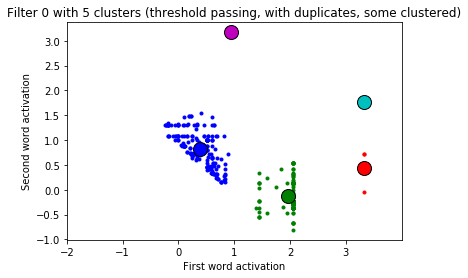

[[ 3.04229302 -0.32489782]
 [ 0.59810543  0.67135589]]


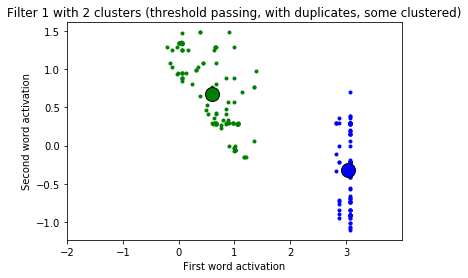

[[ 1.51164474  0.12181766]
 [-0.36756513  1.81850762]
 [ 2.12930679  2.24977031]]


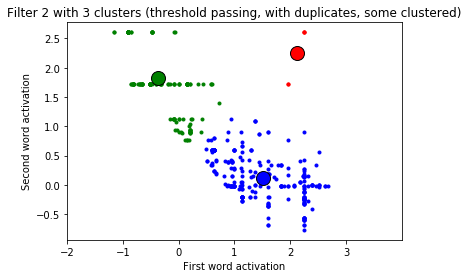

[[ 1.63299702 -0.48320434]
 [ 0.27686202  0.94256679]
 [ 1.63561845  1.04474737]
 [ 0.75374237  0.3579734 ]]


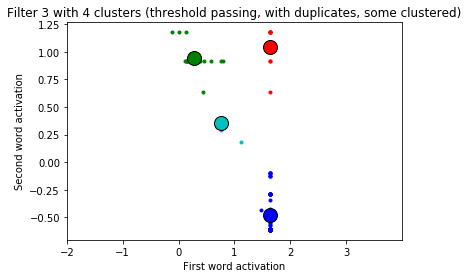

[[ 1.8189356  -0.07142814]
 [-0.08896079  1.00413184]]


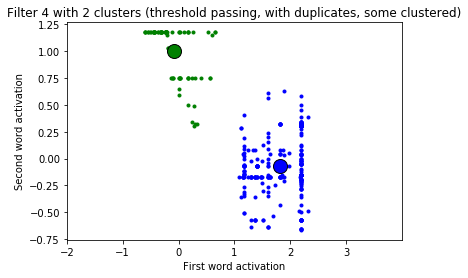

[[1.70631629 0.4685363 ]
 [0.30695112 1.86508297]
 [2.72579598 0.25461365]
 [2.72579598 1.34813964]
 [1.82203162 1.63753366]]


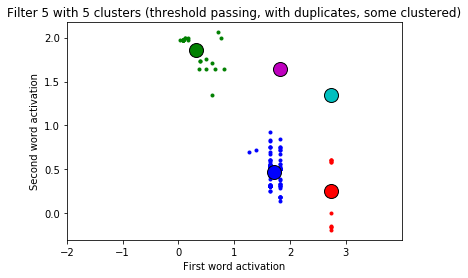

[[1.01061385 0.04751371]]


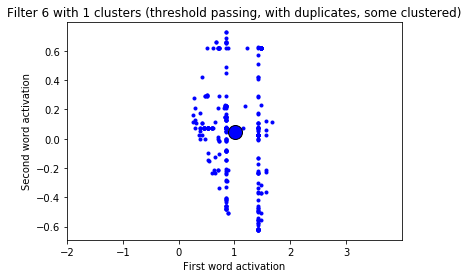

[[ 0.58309624  0.25125433]
 [ 3.89133358  0.16856721]
 [-0.25094682  1.96911871]]


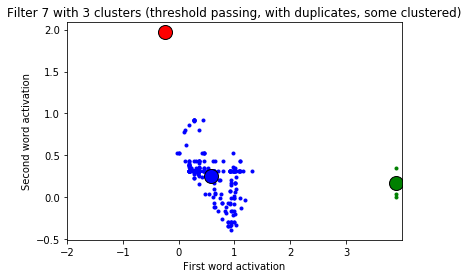

[[0.6717416  1.81494319]]


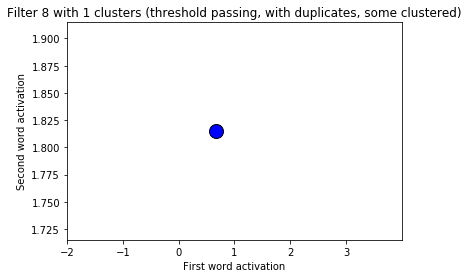

[[ 0.5510258   1.16891587]
 [ 0.11476931  1.16891587]
 [ 2.29368782  1.16891587]
 [ 2.29368782 -0.62700338]
 [ 0.89148057  0.5039795 ]
 [ 0.67272576  0.95074499]
 [ 0.3691637   0.95074499]
 [ 2.29368782  0.47578439]
 [ 2.29368782  0.10357701]
 [ 1.65153241  1.16891587]
 [ 1.65153241  0.03034361]
 [ 1.39890027  1.16891587]
 [ 1.10625219  0.95074499]
 [ 1.04556608  1.16891587]]


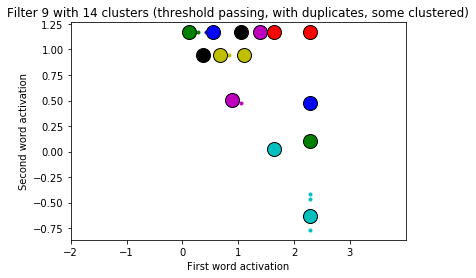

In [47]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2_th_o[filter_ind], X2_th_o[filter_ind], "(threshold passing, with duplicates, some clustered)")

In [48]:
#4
#Bigrams without duplicates, some clustered, threshold passing
X2_th_os, clustering2_th_os = do_clustering(bigrams_th_s, cluster_all=False)
print_clustering_information(clustering2_th_os)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 2 -grams.
Filter 0 centers [[ 0.34777967  0.85547211]
 [ 1.86278227 -0.06177826]
 [ 3.32959962  0.39837688]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]
Number of clusters: 6
Number of instances in cluster 0 148 59.6774 %
Number of instances in cluster 1 54 21.7742 %
Number of instances in cluster 4 1 0.4032 %
Number of instances in cluster 3 1 0.4032 %
Number of instances in cluster -1 40 16.129 %
Number of instances in cluster 2 4 1.6129 %

Filter 1 centers [[ 0.51758685  0.79344317]
 [ 2.96979567 -0.43941124]]
Number of clusters: 3
Number of instances in cluster 1 49 29.697 %
Number of instances in cluster 0 78 47.2727 %
Number of instances in cluster -1 38 23.0303 %

Filter 2 centers [[1.45571953 0.15926236]
 [2.10127163 2.16063148]]
Number of clusters: 3
Number of instances in cluster 0 146 53.0909 %
Number of instances in cluster -1 127 46.1818 %
Number of instances in cluster 1 2 0.7273 %

Filter 3 centers [[ 0.

[[ 0.34777967  0.85547211]
 [ 1.86278227 -0.06177826]
 [ 3.32959962  0.39837688]
 [ 3.32959962  1.77404237]
 [ 0.9350611   3.17082047]]


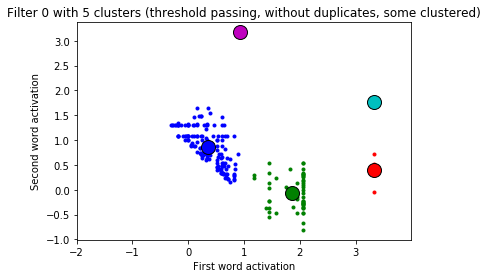

[[ 0.51758685  0.79344317]
 [ 2.96979567 -0.43941124]]


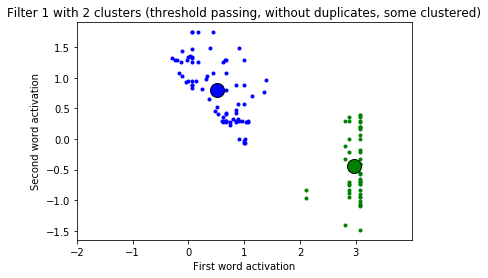

[[1.45571953 0.15926236]
 [2.10127163 2.16063148]]


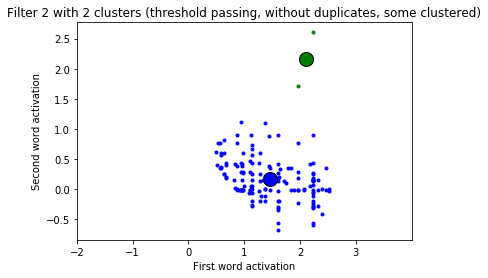

[[ 0.36522357  0.93062382]
 [ 1.62419653 -0.44170179]
 [ 1.63561845  0.24052895]
 [ 0.75374237  0.3579734 ]]


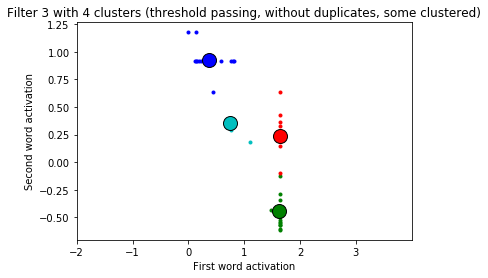

[[ 1.71683255 -0.08399431]
 [ 0.07678921  0.84015977]]


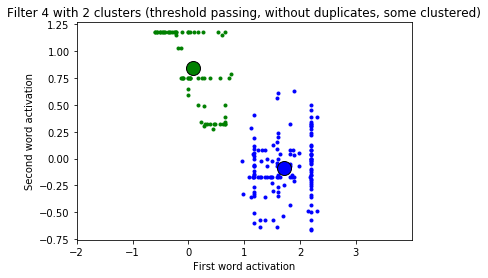

[[1.71296088 0.52080748]
 [0.50163037 1.71329954]
 [2.72579598 0.15452742]
 [2.72579598 1.34813964]
 [1.82203162 1.63753366]]


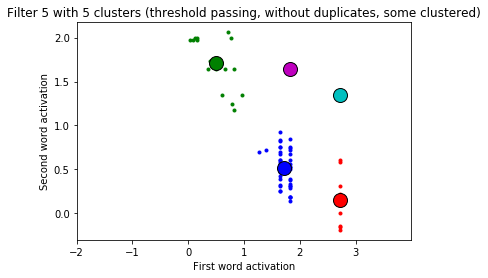

[[ 0.36457905  0.34462007]
 [ 0.99633769 -0.08830433]
 [ 2.37928557 -0.32688653]]


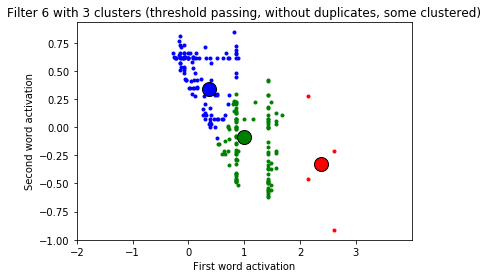

[[ 1.20217515 -0.01352546]
 [ 3.89157677  0.14844071]
 [-0.25094682  1.96911871]]


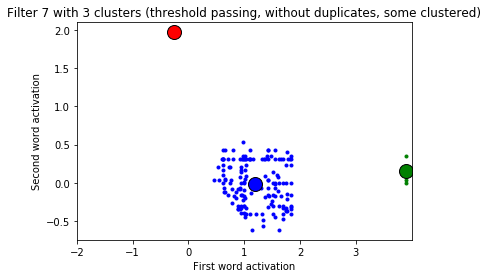

[[0.6717416  1.81494319]]


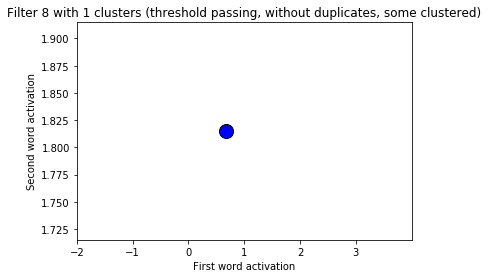

[[ 0.55890952  1.00151641]
 [ 2.29368782 -0.39397989]
 [ 1.7813735   1.16891587]]


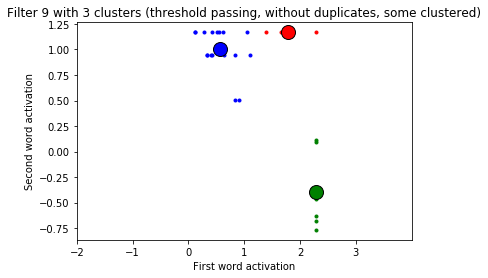

In [49]:
for filter_ind in range(N_FILTERS):
    graph_clusters(filter_ind, clustering2_th_os[filter_ind], X2_th_os[filter_ind], "(threshold passing, without duplicates, some clustered)")

#### Trigrams

In [50]:
#1
#Trigrams with duplicates, all clustered, threshold passing
X3_th, clustering3_th = do_clustering(trigrams_th, cluster_all=True)
print_clustering_information(clustering3_th)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 3 -grams.
Filter 0 centers [[ 0.89686325  0.87396979 -0.12928491]
 [ 0.25888464  1.55022395  0.02811778]
 [-0.30201128  1.5809115   0.2175482 ]
 [ 0.93667189  0.01787367  0.56018012]
 [ 0.32378139  0.54127589  1.00691307]
 [ 0.88526285  0.88141406  1.63280144]
 [ 0.21079817  1.55174518  0.97133156]
 [ 1.27967668  1.97465682  0.27775113]
 [ 0.74785841  1.55174518 -1.00185752]
 [ 0.2652373  -0.5629648   1.82678664]
 [-0.41848606  1.55174518  1.42615902]
 [-1.22488105  1.55174518  1.5474447 ]]
Number of clusters: 12
Number of instances in cluster 0 108 42.6877 %
Number of instances in cluster 4 9 3.5573 %
Number of instances in cluster 1 74 29.249 %
Number of instances in cluster 2 28 11.0672 %
Number of instances in cluster 3 14 5.5336 %
Number of instances in cluster 6 5 1.9763 %
Number of instances in cluster 5 5 1.9763 %
Number of instances in cluster 10 2 0.7905 %
Number of instances in cluster 7 3 1.1858 %
Number of instances

In [51]:
#2
#Trigrams without duplicates, all clustered, threshold passing
X3_th_s, clustering3_th_s = do_clustering(trigrams_th_s, cluster_all=True)
print_clustering_information(clustering3_th_s)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 3 -grams.
Filter 0 centers [[ 0.11172559  1.56230459  0.08083726]
 [ 0.82197214 -0.00195107  0.72841435]
 [ 0.2652373  -0.5629648   1.82678664]]
Number of clusters: 3
Number of instances in cluster 1 34 25.9542 %
Number of instances in cluster 0 94 71.7557 %
Number of instances in cluster 2 3 2.2901 %

Filter 1 centers [[-0.2662831   0.79930427  1.14509584]
 [ 0.51177083  1.0117178  -0.11136914]]
Number of clusters: 2
Number of instances in cluster 0 62 62.0 %
Number of instances in cluster 1 38 38.0 %

Filter 2 centers [[ 1.3561209   0.24554269 -0.00204197]
 [ 1.24867406 -1.10638476  1.46012514]
 [-0.14920576  0.26442582  1.41178982]
 [-0.1978247   1.44809985  0.06044358]]
Number of clusters: 4
Number of instances in cluster 2 30 17.4419 %
Number of instances in cluster 1 46 26.7442 %
Number of instances in cluster 0 93 54.0698 %
Number of instances in cluster 3 3 1.7442 %

Filter 3 centers [[ 0.89534907  0.10915372 -0.09378763

In [52]:
"""

#Concrete trigrams
#Trigram filter 3

filter_ind = 5
v0 = 0
v1 = 1

print("Filter", filter_ind)

ctr = (clustering3_th_s[filter_ind]).cluster_centers_
l = (clustering3_th_s[filter_ind]).labels_

tg3 = ([p for p in result_th_set if len(p[1]) == 3 and p[0]==filter_ind])

assert len(l) == len(tg3)

z = list(zip(tg3, l))

c0 = []
c1 = []

for (p, c) in z:
    if int(c) == v0:
        c0.append(p)
    elif int(c) == v1:
        c1.append(p)
    else:
        pass
        
c0top = get_top_k_ngrams(c0, ngram=3, topk=20)
c1top = get_top_k_ngrams(c1, ngram=3, topk=20)

print("cluster", v0)
print("ctr", ctr[0])
for ngram_ind in [3]:
    print("Observing", ngram_ind, "-grams.")
    for i, row in enumerate(c0top):
        print(i+1, " ".join(row[1]), round(sum(row[2]), 2), row[2])
    print()

print("cluster", v1)
print("ctr", ctr[1])
for ngram_ind in [3]:
    print("Observing", ngram_ind, "-grams.")
    for i, row in enumerate(c1top):
        print(i+1, " ".join(row[1]), round(sum(row[2]), 2), row[2])
    print()
    
"""

'\n\n#Concrete trigrams\n#Trigram filter 3\n\nfilter_ind = 5\nv0 = 0\nv1 = 1\n\nprint("Filter", filter_ind)\n\nctr = (clustering3_th_s[filter_ind]).cluster_centers_\nl = (clustering3_th_s[filter_ind]).labels_\n\ntg3 = ([p for p in result_th_set if len(p[1]) == 3 and p[0]==filter_ind])\n\nassert len(l) == len(tg3)\n\nz = list(zip(tg3, l))\n\nc0 = []\nc1 = []\n\nfor (p, c) in z:\n    if int(c) == v0:\n        c0.append(p)\n    elif int(c) == v1:\n        c1.append(p)\n    else:\n        pass\n        \nc0top = get_top_k_ngrams(c0, ngram=3, topk=20)\nc1top = get_top_k_ngrams(c1, ngram=3, topk=20)\n\nprint("cluster", v0)\nprint("ctr", ctr[0])\nfor ngram_ind in [3]:\n    print("Observing", ngram_ind, "-grams.")\n    for i, row in enumerate(c0top):\n        print(i+1, " ".join(row[1]), round(sum(row[2]), 2), row[2])\n    print()\n\nprint("cluster", v1)\nprint("ctr", ctr[1])\nfor ngram_ind in [3]:\n    print("Observing", ngram_ind, "-grams.")\n    for i, row in enumerate(c1top):\n        prin

In [53]:
#3
#Trigrams with duplicates, some clustered, threshold passing
X3_th_o, clustering3_th_o = do_clustering(trigrams_th, cluster_all=False)
print_clustering_information(clustering3_th_o)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 3 -grams.
Filter 0 centers [[ 0.89686325  0.87396979 -0.12928491]
 [ 0.25888464  1.55022395  0.02811778]
 [-0.30201128  1.5809115   0.2175482 ]
 [ 0.93667189  0.01787367  0.56018012]
 [ 0.32378139  0.54127589  1.00691307]
 [ 0.88526285  0.88141406  1.63280144]
 [ 0.21079817  1.55174518  0.97133156]
 [ 1.27967668  1.97465682  0.27775113]
 [ 0.74785841  1.55174518 -1.00185752]
 [ 0.2652373  -0.5629648   1.82678664]
 [-0.41848606  1.55174518  1.42615902]
 [-1.22488105  1.55174518  1.5474447 ]]
Number of clusters: 13
Number of instances in cluster 0 102 40.3162 %
Number of instances in cluster 4 7 2.7668 %
Number of instances in cluster 1 74 29.249 %
Number of instances in cluster -1 14 5.5336 %
Number of instances in cluster 2 28 11.0672 %
Number of instances in cluster 3 11 4.3478 %
Number of instances in cluster 6 5 1.9763 %
Number of instances in cluster 5 5 1.9763 %
Number of instances in cluster 10 1 0.3953 %
Number of instanc

In [54]:
#4
#Trigrams without duplicates, some clustered, threshold passing
X3_th_os, clustering3_th_os = do_clustering(trigrams_th_s, cluster_all=False)
print_clustering_information(clustering3_th_os)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 3 -grams.
Filter 0 centers [[ 0.11172559  1.56230459  0.08083726]
 [ 0.82197214 -0.00195107  0.72841435]
 [ 0.2652373  -0.5629648   1.82678664]]
Number of clusters: 4
Number of instances in cluster -1 47 35.8779 %
Number of instances in cluster 0 68 51.9084 %
Number of instances in cluster 1 15 11.4504 %
Number of instances in cluster 2 1 0.7634 %

Filter 1 centers [[-0.2662831   0.79930427  1.14509584]
 [ 0.51177083  1.0117178  -0.11136914]]
Number of clusters: 3
Number of instances in cluster -1 20 20.0 %
Number of instances in cluster 0 53 53.0 %
Number of instances in cluster 1 27 27.0 %

Filter 2 centers [[ 1.3561209   0.24554269 -0.00204197]
 [ 1.24867406 -1.10638476  1.46012514]
 [-0.14920576  0.26442582  1.41178982]
 [-0.1978247   1.44809985  0.06044358]]
Number of clusters: 5
Number of instances in cluster 2 25 14.5349 %
Number of instances in cluster 1 41 23.8372 %
Number of instances in cluster 0 84 48.8372 %
Number o

#### Fourgrams

In [55]:
#1
#Fourgrams with duplicates, all clustered, threshold passing
X4_th, clustering4_th = do_clustering(fourgrams_th, cluster_all=True)
print_clustering_information(clustering4_th)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 4 -grams.
Filter 0 centers [[ 0.11941658 -0.21677319  0.05327356  1.05776077]]
Number of clusters: 1
Number of instances in cluster 0 546 100.0 %

Filter 1 centers [[-0.01592607 -0.07848518  0.1220195   0.71311332]]
Number of clusters: 1
Number of instances in cluster 0 754 100.0 %

Filter 2 centers [[0.33327178 0.36573913 0.14872473 0.4732482 ]]
Number of clusters: 1
Number of instances in cluster 0 432 100.0 %

Filter 3 centers [[-0.21505903  2.46004991 -0.43806367  0.46494001]]
Number of clusters: 1
Number of instances in cluster 0 480 100.0 %

Filter 4 centers [[ 0.08789327  1.38984432 -0.23255955 -0.1213025 ]]
Number of clusters: 1
Number of instances in cluster 0 603 100.0 %

Filter 5 centers [[ 0.20970782 -0.22919728  1.07815416  0.09185272]
 [ 0.0842904   2.96262455  0.59681278 -0.53186354]]
Number of clusters: 2
Number of instances in cluster 0 643 98.4686 %
Number of instances in cluster 1 10 1.5314 %

Filter 6 centers

In [56]:
#2
#Fourgrams without duplicates, all clustered, threshold passing
X4_th_s, clustering4_th_s = do_clustering(fourgrams_th_s, cluster_all=True)
print_clustering_information(clustering4_th_s)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 4 -grams.
Filter 0 centers [[ 0.00390374 -0.315816    0.1144726   1.12181732]]
Number of clusters: 1
Number of instances in cluster 0 471 100.0 %

Filter 1 centers [[-0.07922001 -0.13181365  0.31525531  0.65773751]]
Number of clusters: 1
Number of instances in cluster 0 498 100.0 %

Filter 2 centers [[-0.11003956  0.63030137  0.15819694  0.50220448]]
Number of clusters: 1
Number of instances in cluster 0 293 100.0 %

Filter 3 centers [[-0.04454721  0.95935896 -0.29279764  0.75724303]]
Number of clusters: 1
Number of instances in cluster 0 374 100.0 %

Filter 4 centers [[ 0.16419098  1.24855024 -0.25403945 -0.12265396]]
Number of clusters: 1
Number of instances in cluster 0 426 100.0 %

Filter 5 centers [[ 0.23510972 -0.22372459  1.07685744  0.06443756]
 [ 0.0842904   2.96262455  0.59681278 -0.53186354]]
Number of clusters: 2
Number of instances in cluster 0 593 98.3416 %
Number of instances in cluster 1 10 1.6584 %

Filter 6 cen

In [57]:
#3
#Fourgrams with duplicates, some clustered, threshold passing
X4_th_o, clustering4_th_o = do_clustering(fourgrams_th, cluster_all=False)
print_clustering_information(clustering4_th_o)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 4 -grams.
Filter 0 centers [[ 0.11941658 -0.21677319  0.05327356  1.05776077]]
Number of clusters: 2
Number of instances in cluster 0 331 60.6227 %
Number of instances in cluster -1 215 39.3773 %

Filter 1 centers [[-0.01592607 -0.07848518  0.1220195   0.71311332]]
Number of clusters: 2
Number of instances in cluster -1 248 32.8912 %
Number of instances in cluster 0 506 67.1088 %

Filter 2 centers [[0.33327178 0.36573913 0.14872473 0.4732482 ]]
Number of clusters: 2
Number of instances in cluster -1 170 39.3519 %
Number of instances in cluster 0 262 60.6481 %

Filter 3 centers [[-0.21505903  2.46004991 -0.43806367  0.46494001]]
Number of clusters: 2
Number of instances in cluster 0 244 50.8333 %
Number of instances in cluster -1 236 49.1667 %

Filter 4 centers [[ 0.08789327  1.38984432 -0.23255955 -0.1213025 ]]
Number of clusters: 2
Number of instances in cluster -1 252 41.791 %
Number of instances in cluster 0 351 58.209 %

Fil

In [58]:
#4
#Fourgrams without duplicates, some clustered, threshold passing
X4_th_os, clustering4_th_os = do_clustering(fourgrams_th_s, cluster_all=False)
print_clustering_information(clustering4_th_os)

Looking at filter 0 1 2 3 4 5 6 7 8 9 Finished.
Observing 4 -grams.
Filter 0 centers [[ 0.00390374 -0.315816    0.1144726   1.12181732]]
Number of clusters: 2
Number of instances in cluster -1 204 43.3121 %
Number of instances in cluster 0 267 56.6879 %

Filter 1 centers [[-0.07922001 -0.13181365  0.31525531  0.65773751]]
Number of clusters: 2
Number of instances in cluster 0 341 68.4739 %
Number of instances in cluster -1 157 31.5261 %

Filter 2 centers [[-0.11003956  0.63030137  0.15819694  0.50220448]]
Number of clusters: 2
Number of instances in cluster -1 122 41.6382 %
Number of instances in cluster 0 171 58.3618 %

Filter 3 centers [[-0.04454721  0.95935896 -0.29279764  0.75724303]]
Number of clusters: 2
Number of instances in cluster -1 177 47.3262 %
Number of instances in cluster 0 197 52.6738 %

Filter 4 centers [[ 0.16419098  1.24855024 -0.25403945 -0.12265396]]
Number of clusters: 2
Number of instances in cluster 0 277 65.0235 %
Number of instances in cluster -1 149 34.9765 

### Negative ngrams

In [59]:
def printout5(d):
    for row in d[:10]:
        print(" ".join(row[0][1]), "\t", [round(e, 2) for e in row[0][2]], "\t", "diff:", round(row[1], 2))
        
def print_dict(d):
    for k, v in d.items():
        print("Orig:", k)
        close = sorted(v, key=lambda e: abs(e[1]), reverse=True)
        printout5(close)
        print()

In [60]:
#Bigrams
def get_negative_ngrams(ngram):
    d = defaultdict(list)
    for filter_ind in range(N_FILTERS):
        ng = get_top_ngrams(result_set, ngram=ngram, f=filter_ind)
       
        for topk, pair in enumerate(ng[:10]): #10 biggest activation ngrams
            for row in ng: #Compare with all ngrams
                if ngram==2:
                    if row[1][0] == pair[1][0] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))  
                    elif row[1][1] == pair[1][1] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
                elif ngram==3:
                    if row[1][1:] == pair[1][1:] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
                    elif row[1][0] == pair[1][0] and row[1][2] == pair[1][2] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
                    elif row[1][:-1] == pair[1][:-1] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
                elif ngram==4:
                    if row[1][1:] == pair[1][1:] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
                    elif row[1][0] == pair[1][0] and row[1][2] == pair[1][2] and row[1][3] == pair[1][3] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
                    elif row[1][0] == pair[1][0] and row[1][1] == pair[1][1] and row[1][3] == pair[1][3] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
                    elif row[1][:-1] == pair[1][:-1] and row != pair:
                        d[pair].append((row, sum(pair[2]) - sum(row[2])))
    return d         

In [61]:
d_b = get_negative_ngrams(2)
print_dict(d_b)

Orig: (0, ('went', 'overboard'), (3.329599618911743, 1.7740423679351807))
going overboard 	 [0.16, 1.77] 	 diff: 3.17
went over 	 [3.33, -0.05] 	 diff: 1.82
went up 	 [3.33, 0.42] 	 diff: 1.36
went into 	 [3.33, 0.51] 	 diff: 1.26
went down 	 [3.33, 0.71] 	 diff: 1.06

Orig: (0, ('already', 'eaten'), (0.9350610971450806, 3.170820474624634))
already said 	 [0.94, -0.77] 	 diff: 3.94
already has 	 [0.94, -0.67] 	 diff: 3.85
already is 	 [0.94, -0.64] 	 diff: 3.81
already had 	 [0.94, -0.61] 	 diff: 3.78
already been 	 [0.94, -0.59] 	 diff: 3.76
already . 	 [0.94, -0.46] 	 diff: 3.64
already have 	 [0.94, -0.41] 	 diff: 3.58
already done 	 [0.94, -0.3] 	 diff: 3.47
already waiting 	 [0.94, -0.3] 	 diff: 3.47
already on 	 [0.94, -0.28] 	 diff: 3.45

Orig: (0, ('went', 'down'), (3.329599618911743, 0.7115429639816284))
is down 	 [-1.18, 0.71] 	 diff: 4.51
for down 	 [-1.14, 0.71] 	 diff: 4.47
comes down 	 [-0.89, 0.71] 	 diff: 4.22
standing down 	 [-0.8, 0.71] 	 diff: 4.13
one down 	 [-0.8, 

woman drying 	 [-0.78, 0.33] 	 diff: 2.42

Orig: (3, ('above', 'uh'), (0.9737836122512817, 0.914050817489624))
's uh 	 [-1.58, 0.91] 	 diff: 2.56
the uh 	 [-1.34, 0.91] 	 diff: 2.31
spill uh 	 [-1.33, 0.91] 	 diff: 2.3
pan uh 	 [-1.24, 0.91] 	 diff: 2.21
was uh 	 [-1.2, 0.91] 	 diff: 2.17
will uh 	 [-1.12, 0.91] 	 diff: 2.09
be uh 	 [-1.1, 0.91] 	 diff: 2.08
that uh 	 [-1.1, 0.91] 	 diff: 2.07
have uh 	 [-1.01, 0.91] 	 diff: 1.99
she uh 	 [-0.98, 0.91] 	 diff: 1.95

Orig: (3, ('kitchen', 'curtains'), (1.6356184482574463, 0.145058736205101))
's curtains 	 [-1.58, 0.15] 	 diff: 3.22
the curtains 	 [-1.34, 0.15] 	 diff: 2.98
her curtains 	 [-0.93, 0.15] 	 diff: 2.57
has curtains 	 [-0.88, 0.15] 	 diff: 2.52
uh curtains 	 [-0.78, 0.15] 	 diff: 2.42
is curtains 	 [-0.68, 0.15] 	 diff: 2.31
are curtains 	 [-0.49, 0.15] 	 diff: 2.12
um curtains 	 [-0.49, 0.15] 	 diff: 2.12
of curtains 	 [-0.48, 0.15] 	 diff: 2.12
those curtains 	 [-0.48, 0.15] 	 diff: 2.12

Orig: (3, ('describe', 'uh'), (0.82

In [62]:
d_t = get_negative_ngrams(3)
print_dict(d_t)

Orig: (0, ('hm', 'hm', 'cup'), (1.2796766757965088, 1.9746568202972412, 0.6348846554756165))
hm hm I 	 [1.28, 1.97, -0.1] 	 diff: 0.73
hm hm that 	 [1.28, 1.97, 0.29] 	 diff: 0.34

Orig: (0, ('hm', 'hm', 'that'), (1.2796766757965088, 1.9746568202972412, 0.2942453920841217))
. hm that 	 [-1.93, 1.97, 0.29] 	 diff: 3.21
hm and that 	 [1.28, -0.94, 0.29] 	 diff: 2.92
hm that that 	 [1.28, -0.91, 0.29] 	 diff: 2.88
hm hm I 	 [1.28, 1.97, -0.1] 	 diff: 0.39
hm hm cup 	 [1.28, 1.97, 0.63] 	 diff: -0.34

Orig: (0, ('gon', 'na', 'upset'), (0.8852628469467163, 0.8814140558242798, 1.6719346046447754))
gon na tip 	 [0.89, 0.88, -1.57] 	 diff: 3.24
gon na give 	 [0.89, 0.88, -1.14] 	 diff: 2.81
gon na hit 	 [0.89, 0.88, -1.12] 	 diff: 2.79
gon na break 	 [0.89, 0.88, -1.08] 	 diff: 2.75
gon na hand 	 [0.89, 0.88, -1.04] 	 diff: 2.72
gon na pass 	 [0.89, 0.88, -0.93] 	 diff: 2.61
gon na go 	 [0.89, 0.88, -0.76] 	 diff: 2.43
gon na get 	 [0.89, 0.88, -0.71] 	 diff: 2.38
gon na tell 	 [0.89, 0.88, -0

Orig: (4, ('guess', 'the', 'mother'), (0.5410080552101135, -0.08149336278438568, 2.311270236968994))
guess the water 	 [0.54, -0.08, -0.8] 	 diff: 3.11
guess the girl 	 [0.54, -0.08, 0.15] 	 diff: 2.16
's the mother 	 [-1.45, -0.08, 2.31] 	 diff: 2.0
be the mother 	 [-1.44, -0.08, 2.31] 	 diff: 1.98
and the mother 	 [-1.35, -0.08, 2.31] 	 diff: 1.89
on the mother 	 [-1.35, -0.08, 2.31] 	 diff: 1.89
in the mother 	 [-1.25, -0.08, 2.31] 	 diff: 1.79
lady the mother 	 [-1.18, -0.08, 2.31] 	 diff: 1.72
her the mother 	 [-1.14, -0.08, 2.31] 	 diff: 1.68
as the mother 	 [-1.08, -0.08, 2.31] 	 diff: 1.62

Orig: (4, ('uh', 'the', 'mother'), (0.22671665251255035, -0.08149336278438568, 2.311270236968994))
uh the uh 	 [0.23, -0.08, -1.28] 	 diff: 3.6
uh the not 	 [0.23, -0.08, -1.24] 	 diff: 3.55
uh the cup 	 [0.23, -0.08, -1.23] 	 diff: 3.54
uh the cups 	 [0.23, -0.08, -1.18] 	 diff: 3.49
uh the the 	 [0.23, -0.08, -1.05] 	 diff: 3.36
uh the windows 	 [0.23, -0.08, -1.05] 	 diff: 3.36
uh the cab

In [63]:
d_f = get_negative_ngrams(4)
print_dict(d_f)

Orig: (0, ('gon', 'na', 'upset', '.'), (0.7905185222625732, 0.37882038950920105, 1.4576411247253418, 1.3926165103912354))
gon na fall . 	 [0.79, 0.38, -0.15, 1.39] 	 diff: 1.6
gon na upset the 	 [0.79, 0.38, 1.46, -0.18] 	 diff: 1.57
gon na show . 	 [0.79, 0.38, 0.24, 1.39] 	 diff: 1.22
gon na beep . 	 [0.79, 0.38, 0.72, 1.39] 	 diff: 0.74

Orig: (0, ('mhm', '.', 'oh', '.'), (0.7550694942474365, -0.3630788028240204, 1.518726110458374, 1.3926165103912354))
it . oh . 	 [-2.83, -0.36, 1.52, 1.39] 	 diff: 3.58
me . oh . 	 [-2.18, -0.36, 1.52, 1.39] 	 diff: 2.94
overflowing . oh . 	 [-1.31, -0.36, 1.52, 1.39] 	 diff: 2.07
cookie . oh . 	 [-1.18, -0.36, 1.52, 1.39] 	 diff: 1.93
mhm . oh the 	 [0.76, -0.36, 1.52, -0.18] 	 diff: 1.57
mhm . okay . 	 [0.76, -0.36, 0.1, 1.39] 	 diff: 1.42
mhm . oh I 	 [0.76, -0.36, 1.52, 0.04] 	 diff: 1.36
lady . oh . 	 [-0.35, -0.36, 1.52, 1.39] 	 diff: 1.11
mhm . alright . 	 [0.76, -0.36, 0.47, 1.39] 	 diff: 1.05
alright . oh . 	 [-0.15, -0.36, 1.52, 1.39] 	 di

Orig: (4, ('curtains', 'are', 'open', 'and'), (0.709286093711853, 2.3505396842956543, 1.8396155834197998, -0.32234615087509155))
faucets are open and 	 [-0.41, 2.35, 1.84, -0.32] 	 diff: 1.12
curtains are open to 	 [0.71, 2.35, 1.84, -0.78] 	 diff: 0.46
curtains are open . 	 [0.71, 2.35, 1.84, 0.06] 	 diff: -0.38

Orig: (4, ('feet', 'are', 'getting', 'soaking'), (1.388287901878357, 2.3505396842956543, -0.19691044092178345, 0.9475868940353394))
feet are getting wet 	 [1.39, 2.35, -0.2, 1.68] 	 diff: -0.74

Orig: (4, ('to', 'be', 'quiet', '.'), (0.7137236595153809, 1.7038240432739258, 1.9399386644363403, 0.05732157081365585))
to be washed . 	 [0.71, 1.7, -1.94, 0.06] 	 diff: 3.88
to be hurt . 	 [0.71, 1.7, -1.43, 0.06] 	 diff: 3.37
to be more . 	 [0.71, 1.7, -1.28, 0.06] 	 diff: 3.22
to be careful . 	 [0.71, 1.7, -0.61, 0.06] 	 diff: 2.55
to be movement . 	 [0.71, 1.7, 0.0, 0.06] 	 diff: 1.94
to be action . 	 [0.71, 1.7, 0.17, 0.06] 	 diff: 1.77
to be quiet because 	 [0.71, 1.7, 1.94, -1

### Interpreting concrete texts

In [64]:
def interpret(data, ths, key=None):
    cnt = Counter()
    
    for item_index, item in enumerate(data):
        prediction = predict(item, tensor=False) #0 või 1
        print("Prediction is", prediction, "-", LABEL.vocab.itos[prediction], round(predict(item, False, False).item(), 2))
        judge = judgement(item, prediction) #tn/fn/tp/fp
        slot_activations = list(set(generate_slot_activation_vectors([item])))
        
        if key is None or judge == key:
            total_score = 0
            print(" ".join(item.text), item.label)
            print()
            print("The judgement is", judge)
            
            tensor = construct_tensor(item)
            
            pooled_ind = best_model.max_unigrams(tensor)
            
            for i, pooled in enumerate(pooled_ind):
                print(str(FILTER_SIZES[i]) + "-grams")
                
                #Max-pooled vector activations, indices and linear layer weights
                params = list(zip(pooled[0].squeeze().detach().numpy(), pooled[1].squeeze().detach().numpy(), 
                                  best_model.fc.weight.data.squeeze().detach().numpy()[i*N_FILTERS:(i+1)*N_FILTERS]))
                
                for filter_ind, (score, idx, weight) in enumerate(params):
                    #print(filter_ind)
                    word = ' '.join(item.text[idx:idx+FILTER_SIZES[i]])
                    t = round(correct_thresholds[i][filter_ind], 2)
                    w = score*weight
                    
                    s = list(filter(lambda e: " ".join(e[1]) == word and e[0] == filter_ind, slot_activations))[0]
                    
                    f_c = LABEL.vocab.itos[filter_class(best_model, filter_ind, FILTER_SIZES[i])]
                    
                    print("\t".join((str(filter_ind), str(t), f_c, word, "\t".join(map(lambda e: str(round(e, 2)), s[2])), "Y" if sum(s[2])>t else "")))
                    cnt[word] += score * weight
                    total_score += score * weight
                    
            total_score += best_model.fc.bias.data.item()
            print()
#interpret(test_data, correct_thresholds, "fp")

In [65]:
interpret([test_data[28]], correct_thresholds, "tp")

Prediction is 0 - P 0.01
girl washing dishes . I see that . uh what the boy 's putting up the cookie jar or getting cookies out of the cookie jar . and his little sister is begging him . oh hurry up . come on . and he 's got the foot stool . and his her big sister is washing the dishes . that 's the big sister or the mama I do n't know which that is is drying the dishes , putting them away . she 's got the spigot on and the water 's running . and there 's her cup . she has n't them put up yet . and he 's up on the foot stool . and he 's got the cookie jars . he 's getting the cookie jars . she 's begging him for some . begging him for some cookies . she 's washing the dishes uh she 's drying the dishes . and she 's got the water on in the sink . and there 's her cup sitting down there . , to be washed . no she has an apron on and her shoes . and the drapes are pulled back in one of the rooms . see ? P

The judgement is tp
1-grams
0	3.04	P	begging	1.0	
1	0.72	C	putting	0.29	
2	3.18	P	so

In [66]:
interpret([test_data[50]], correct_thresholds, "tn")

Prediction is 1 - C 0.99
okay . the little boy is climbing up in the getting cookies out of the cookie jar and is he 's falling . the stool 's falling over . and the little girl has her hand up that she wants a cookie and he 's trying to hand her one . and the door to the cabinet is open . and the mother is washing dishes . and the the dish water is overflowing in the sink and it 's running on to the floor and she 's standing in the water . and there 's she 's drying a plate or washing it . whatever . and there 's two cups and a plate on the counter top . and it looks like the window is open . and it has curtains pulled back at the window . and there 's a little lane going around the house towards the back I imagine with shrubs . and you can see another window . C

The judgement is tn
1-grams
0	3.04	P	floor	3.04	Y
1	0.72	C	towards	0.71	
2	3.18	P	up	2.11	
3	2.24	P	over	0.66	
4	0.96	P	imagine	0.15	
5	0.22	C	open	3.44	Y
6	0.57	P	trying	2.4	Y
7	0.7	C	cabinet	1.62	Y
8	1.07	C	stool	0.82	
9	2

In [67]:
interpret([test_data[4]], correct_thresholds, "fn")

Prediction is 1 - C 0.71
hm . the little boy is on the stool which is tipping and he wants cookies to give to his sister . he has a handful of cookies in one hand already and the little girl is eating a cookie . the mother is washing dishes absentmindedly . she let the sink run over and it 's all on the floor . there 's a window with you can see their driveway . either bushes or trees and grass a big window . and a tree coming up here . and the part of the roof . and the cookie says cookie jar . P

The judgement is fn
1-grams
0	3.04	P	floor	3.04	Y
1	0.72	C	already	0.98	Y
2	3.18	P	all	2.17	
3	2.24	P	their	0.79	
4	0.96	P	here	1.23	Y
5	0.22	C	grass	0.13	
6	0.57	P	coming	0.62	Y
7	0.7	C	says	0.12	
8	1.07	C	stool	0.82	
9	2.32	P	hm	0.83	
2-grams
0	0.9	P	already and	0.94	-0.31	
1	0.9	P	dishes absentmindedly	0.85	0.0	
2	0.84	P	hm .	2.24	-0.03	Y
3	1.01	C	window .	0.76	-0.6	
4	0.58	P	tipping and	-0.11	0.32	
5	1.88	P	his sister	1.82	-0.84	
6	0.36	C	wants cookies	1.0	-0.73	
7	0.5	P	tipping and	0.07

In [68]:
interpret([test_data[33]], correct_thresholds, "fp")

Prediction is 0 - P 0.02
uh inside the room or every place ? oh I can oh you do n't want me to memorize it ! oh . okay , the the little girl asking for the cookie from the boy who 's about to fall on his head . and she 's going I guess “ shush ” or “ give me one ” . the mother 's we do n't think she might be on drugs because uh she 's off someplace because the sink 's running over . and uh it 's summer outside because the window 's open and the grasses or the bushes look healthy ... and uh she 's drying dishes with her apron on . and the cookie jar 's looking full . that 's it . C

The judgement is fp
1-grams
0	3.04	P	room	1.41	
1	0.72	C	summer	1.22	Y
2	3.18	P	n't	2.13	
3	2.24	P	over	0.66	
4	0.96	P	oh	1.63	Y
5	0.22	C	open	3.44	Y
6	0.57	P	head	2.19	Y
7	0.7	C	head	0.58	
8	1.07	C	memorize	0.0	
9	2.32	P	head	1.85	
2-grams
0	0.9	P	his head	0.51	0.45	Y
1	0.9	P	guess “	0.52	-0.06	
2	0.84	P	! oh	1.6	-0.32	Y
3	1.01	C	and uh	-0.29	0.91	
4	0.58	P	... and	2.2	0.32	Y
5	1.88	P	her apron	1.65	-0.11	


### Predicting concrete texts

In [69]:
def predict_diagnosis(text, min_len=5):
    """
    Predicts the diagnosis based on the given text string.
    """
    tokenised = tokenizer(text)
    if len(tokenised) < min_len:
        tokenised += ['<pad>'] * (min_len - len(tokenised))
    indexed = [TEXT.vocab.stoi[t] for t in tokenised]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(best_model(tensor)).squeeze()
    return prediction.item()

In [70]:
#test
predict_diagnosis("""what 's going ... boy 's reaching a cookie jar . the the stool is falling over . the uh girl is holding her hand up for a cookies . and uh and then they wove in the picture mother the water is overflowing from the sink . she 's drying dishes . she 's looking out a window . water 's on the floor . she 's looking out the ... well there 's the the the the curtains are pulled aside . there 's dishes on the table . and you can see the grass outside in the yard . dish in her hand .""")

0.6555086970329285

In [71]:
#Patient - close to 0
predict_diagnosis("""mhm . well this one is in the cookie jar . and this is she tried to climb the uh ... oh no no . this boy I think this is the same one huh tried to get in the cookie jar . and she's watching . and over here must be the mother . I don't know what the heck they're doing here though . what's going on ? the stool she was climbing and the stool tipped over . she was doing the dishes I think . she spilled something .""")

0.0012231965083628893

In [72]:
#Control - close to 1
predict_diagnosis("""uh there's a boy reaching on he's on a stool reaching for cookies and the stool is ready to fall over . uh he's got one hand in the cookie jar and he's got a cookie in the left hand . and his girl's standing beside him . am I going to fast ? and uh she's reaching for the cookie that he has in his hand . and she has her right finger up to her wrist . uh there's a woman presumably the mother standing at the sink drying dishes . and the sink is overflowing with water onto the floor . um you just want the action ? you just want the action . faucet the water's coming out of the faucet .""")

0.9914585947990417